# Informed Classifier

## Notes about the Project
Instead of working directly in jupyter notebook for this project and having the majority of the codebase in here, there is a separate repository (all progress is on the main branch) here: [https://github.com/JuLieAlgebra/informed_classifier](https://github.com/JuLieAlgebra/informed_classifier). 

I condense what's relevant from the repository into its corresponding sections, but will include as many links to the relevant files as possible! Since it would involve considerable work and seems like it wouldn't add to the report, I will not try to make all of the code snippets runnable from this notebook and will include photos/rendered markdown where it's not supposed to be runnable. There are setup instructions in the README if you would like to run anything yourself!

I'll occasionally be swapping between calling these time series Process A & B and calling them nominal and disrupted. Process B will always be the disrupted case and Process A will be the nominal case. I'll talk about the design process for these distributions in the Generative Processes section (including why the covariance and mean functions look the way they do).
I also vary between calling them 100-dimensional Gaussians and finite-time, discrete Gaussian Process.

Hopefully that's all ok!

In [1]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt

# My module is called informed_classification!
import informed_classification.generative_models
import informed_classification.bayes_classifier
import informed_classification.naive_ml
import informed_classification.models

## Project Introduction: Time Series Classification
Imagine we have two time series and our task is to distinguish between them. 

We have a dataset of samples from each time series and each one is perfectly labelled (no mistakes).

How would you approach building a classifier for these series? 

They look almost identical, though there's some more high frequency noise in the Disrupted time series samples and overall more variance. Maybe you'd explore engineering some good features for a neural network or a decision tree that would capture the high frequency content of the second time series. Maybe you'd fit the mean with a polynomial and the noise with a seasonal ARMA -- there does seem to be a "random walk" element to the processes, with maybe periodic noise on top of the disrupted model.

It wouldn't be very easy! Even by eye, this is a difficult challenge. Here's one sample from one of the two processes. Which one would you think it came from?



....
Nominal!

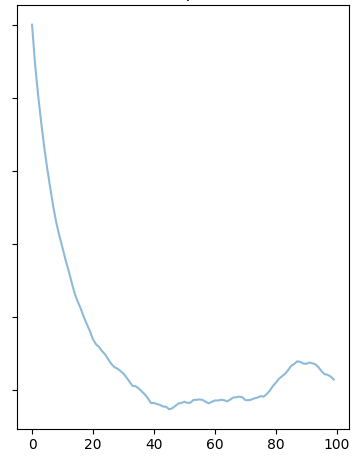

....
Disrupted!

### If you know the conditional distributions, Bayes is Best
What if you knew the process that both of these series came from perfectly? If you can write down P(data|C=c) and knew the true proportion of each class (to form the right prior), using a Bayes classifier would give you optimal results. Here's a proof of that! [Proof here](https://en.wikipedia.org/wiki/Bayes_classifier).

In other words, the error rate of the Bayes classifier is the minimum possible error you could expect among any classifier, as long as you have the correct pieces of the Bayes rule. There's more discussion on that [here](https://web.engr.oregonstate.edu/~ktumer/publications/files/tumer-ghosh_jsesd03.pdf) and [here](https://machinelearningmastery.com/bayes-optimal-classifier/).

### But what if you don't?
But what if you didn't know each process's distribution perfectly? What if you only had partial knowledge about each one? How much knowledge do you need to have about class A or class B before
modeling those classes directly outperformed something like a vanilla neural network for classification?

In this work, I will set up an example situation to, hopefully, help answer that question.
I’ll define two processes with different distributions (Process A and B or Nominal and Disrupted, which you saw examples of above) and use them to generate the dataset for this work. Then, I will fit new models based on differing levels of prior knowledge about the true distributions, in order to sweep
this gray area of prior knowledge. I’ll compare performance to the perfectly-known ground truth, the perfect Bayes Classifier using the true distributions, and a baseline discriminative model that will represent **no** prior knowledge about A or B. 

## Code Organization
The associated repo is here: https://github.com/JuLieAlgebra/informed_classifier.

The project (`informed_classifier`) is set up in the following way (ignoring hidden files like `.gihub`):

.\
├─ config\
│   ├── large_samples.yaml\
│   ├── medium_samples.yaml\
│   ...\
├─ data\
│   ├── Example experiment name: 100dim_10000samples_0.5ratio_0.0006train_0.8994test_0.1val\
│   │   ├── test\
│   │   ├── train\
│   │   └── validation\
│   ...\
├─ gen_data.py\
├─ informed_classification\
│   ├── `__init__`.py\
│   ├── `bayes_classifier.py`: The Bayes classifier class\
│   ├── `common_utilities.py`: Utilities like command line interfaces, loading config files, ...\
│   ├── `generative_models.py`: Defines the underlying process models\
│   ├── `models.py`: Fitted gaussian process models\
│   ├── `analysis.py`: Contains functions for generating most of the plots\
│   └── `naive_ml.py`: (Unused) Implementation of a shallow neural network as a baseline model\
├─ poetry.lock\
├─ pyproject.toml\
├─ README.md\
├─ Report.ipynb\
├─ scripts\
│   ├── `disrupted.py`: Script used for generating some figures for the proposal report\
│   ├── `evaluate_bayes.py`: For a fixed train/test/val split, evaluate the fitted and true Bayes classifiers\
│   ├── `evaluate_kfold_bayes.py`: For a range of training set sizes, evaluate the average performance of fitted Bayes model\
│   ├── `evaluate_kfold_svm.py`: For a range of training set sizes, evaluate the average performance of SVM model\
│   ├── `evaluate_....py`: There are a few analysis scripts being written to generate some last-minute additional figures.\
│   └── `evaluate_svm.py`: Another example discriminative model\
└─ tests\
    ├── test_gen_models.py\
    └── test_models.py


If you'd like, you can install Poetry and follow the three lines in the README to run this work for yourself.
There are tests for every module within.

Some small quality of life additions is a basic CI that runs the existing tests on every push so I can't commit code that breaks existing functionality without knowing about it (and ensure that the project enviroment is always fully specified). I also have style linters running with pre-commit hooks -- both `isort` and `black`, which manage the organization of your import statements and the code style.

# Dataset
## Generative processes

This will serve as a proxy for a nominal state and a perturbed, anomalous state of a dynamical system.
• Process A (representing a nominal state): (Discrete, finite-time) Gaussian Process with mean ($mu_B$ , covariance $\sigma_B^2)$
- Process B (representing an anomalous state): (Discrete, finite-time) Gaussian Process ($mu_B$ , covariance $\sigma_B^2)$

I went through several iterations of designing these processes. It was quite challenging to make trajectories (samples from our 100-dim Gaussian / a sample from our finite-time, discrete Gaussian Process) that were distinguishable by eye, but were not trival to classify. The initial plot I showed in the project report generated 100% accuracy from the true-distribution Bayes classifier, almost 100% accuracy from the SVM and the fitted GP models.

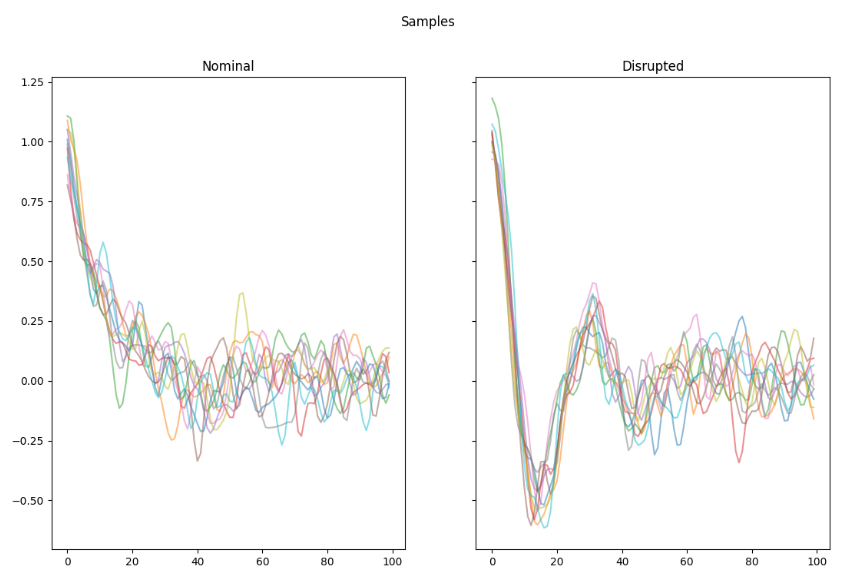\
***Figure: Old process models that were too easy for all models to distinguish between***

Process A represents a "normal" or "nominal" run of a machine, trajectory of a dynamical system, etc. Process B was designed to be an augmented version of Process A, with additional terms in the covariance matrix to simulate "something going wrong". That might be additional higher-frequency, correlated vibrations in your experiment setup from something like a loose screw! Or something more like an additional force you didn't expect (though most forces wouldn't end up in your covariance matrix like that).

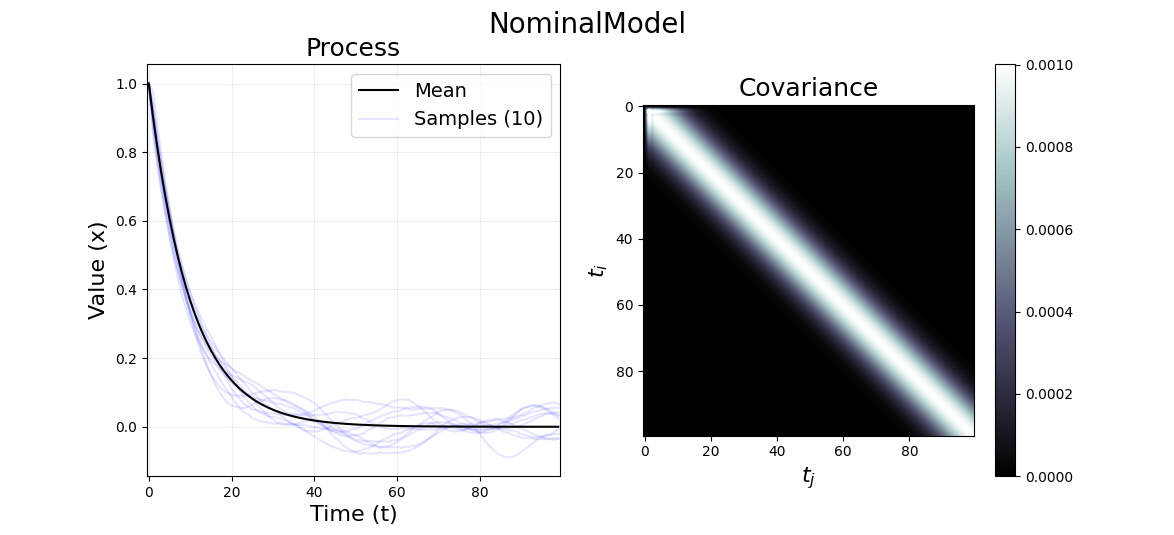\
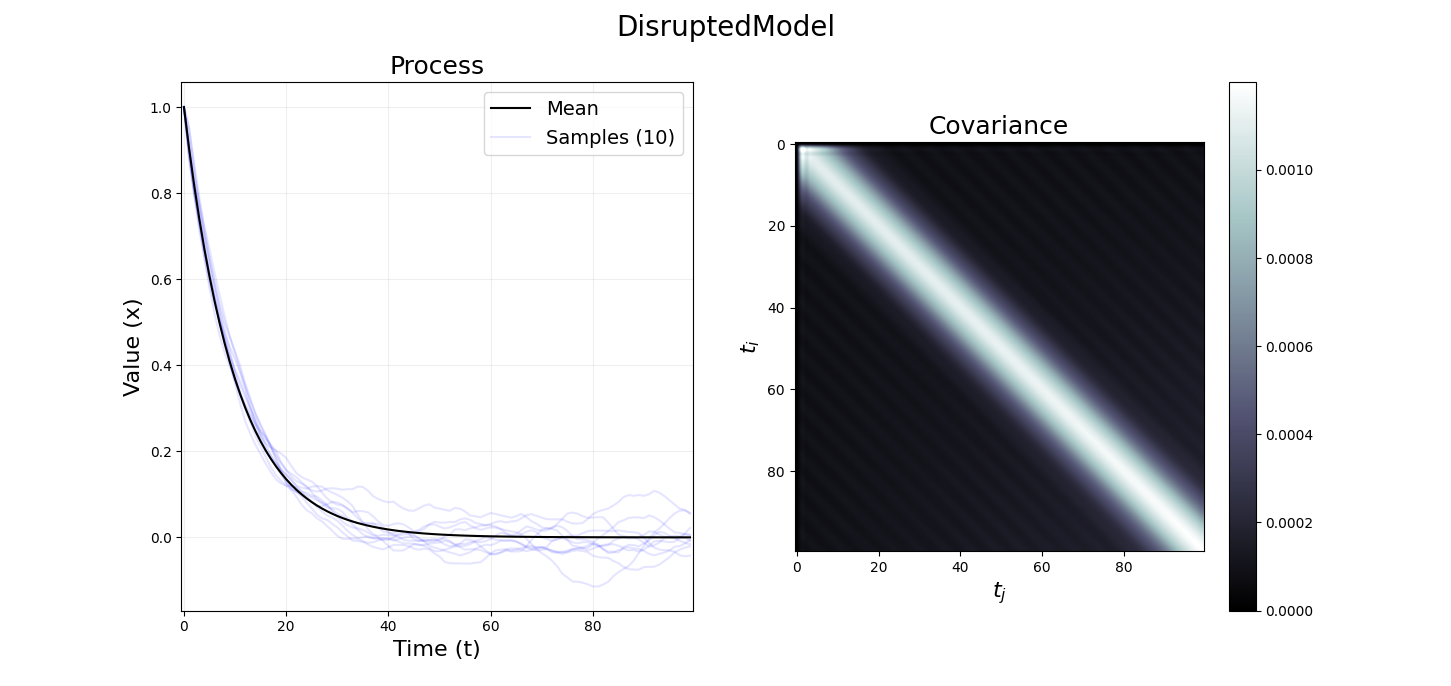

### Covariance Matrix Design
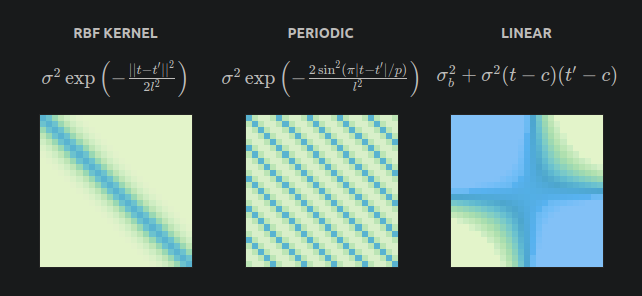\
***Figure: Kernel / covariance matrix types for Gaussian Processes, from [Ref 1. Distill.io](https://distill.pub/2019/visual-exploration-gaussian-processes/)***

The covariance matrix for Process B was chosen to be a linear combination of both periodic and an RBF kernel elements, plus a small amount of noise. This added correlations to the time series for elements that were not contiguous. You'll see in the later sections how well the fitted models learn this more complex kernel. Process A's covariance matrix was an RBF kernel with a small amount of noise added.

### Structure and Discussion
You can see the associated file here! https://github.com/JuLieAlgebra/informed_classifier/blob/main/informed_classification/generative_models.py

The GenerativeModel class is the base class for Nominal, Disrupted, and the FittedGaussian models we'll talk about after the Bayes classifier. It doesn't do anything on its own, but defines the necessary components for a model to be used for a Bayes classifier class.

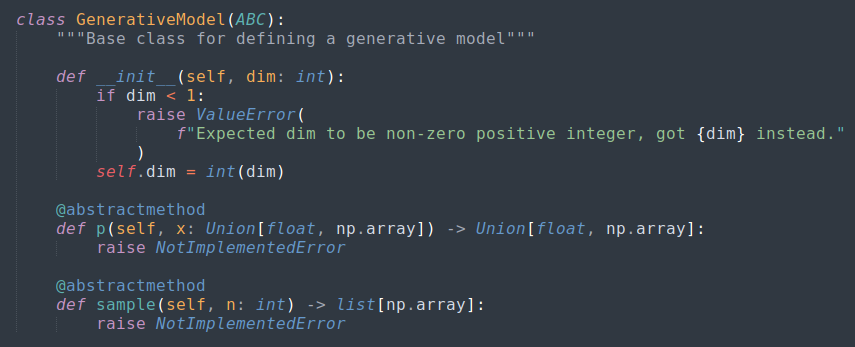

The Nominal and Disrupted models have identical mean functions, up to a perturbance factor that will be 0.0 (so not present) at all for all these results unless otherwise stated. In the section "Model Accuracy over Increased Disruption", we will see the results of parameter sweeps over that value and the covariance disturbance value as well.

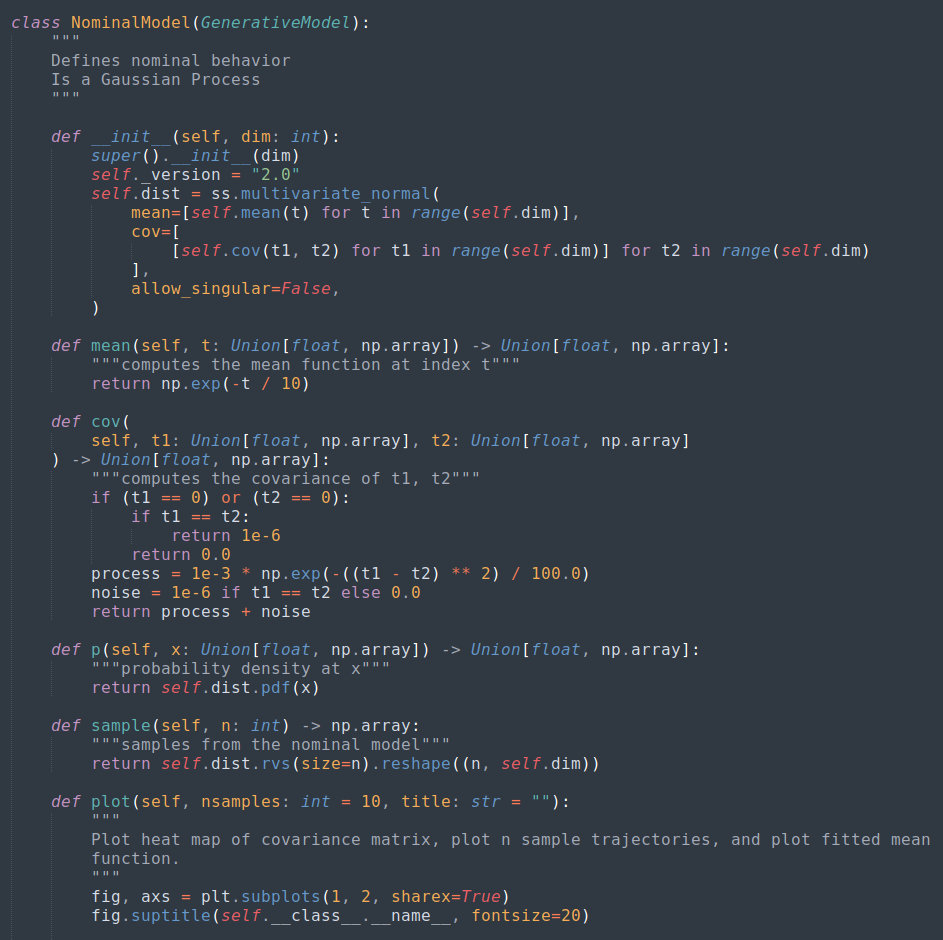

Both models have a sampling function implemented (just for introspection, not needed for the classification task) and are able to query the PDF's of their wrapped scipy distributions. They define their own mean and covariance functions as well.

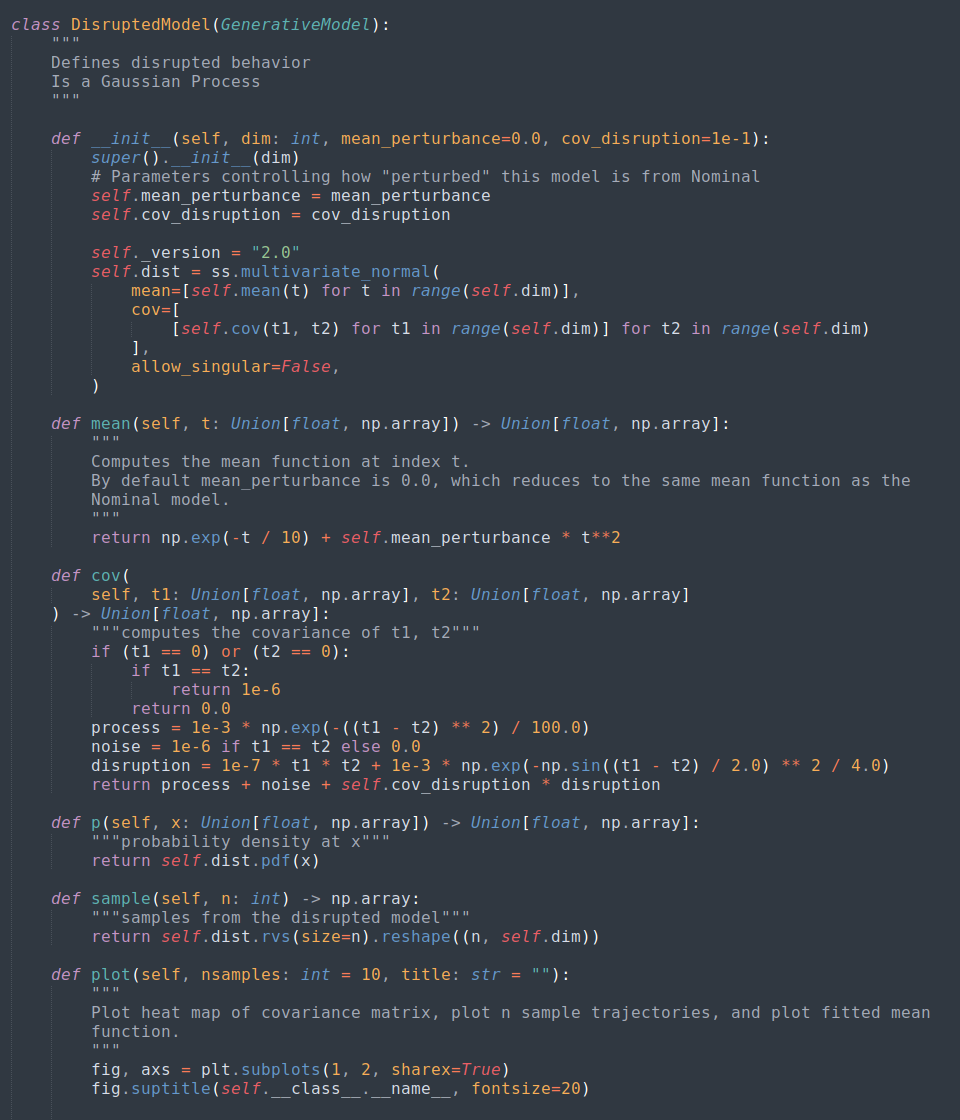

Again the plot functions are not included in the code snippet since they're long and not very important, but please feel free to look at them if you're interested! You'll see the results of calling those functions through the report though.

## Data Preparation
Each generative model is versioned and data is generated through ```poetry run python gen_data.py --config config_file_name.yaml```.
The data is then saved as separate npy files (one per sample trajectory) under the full experiment name (versioned with the contents of the config file and the version of the generative models) into separate directories for `train`, `test`, and `validation` splits. You can see how this is organized in "Overview of Code" section.

`gen_data.py` instantiates a nominal and disrupted model and generates samples from each. The labels are created based on which model was called, the data is shuffled, and then saved to file.

In [2]:
# To generate the large dataset (50k samples), uncomment and run this cell
# !poetry run python gen_data.py --config large_samples.yaml

<!-- ### Subset `gen_data` script to be runnable here:

```py
### CONFIGURATION
config, config_filename = get_config()
dim = config["dim"]
samples = config["samples"]
ratio = config["ratio"]
train_test_validation_split = config["train_test_validation_split"]
assert np.isclose(sum(train_test_validation_split), 1.0)

#### MODELS
disrupted = generative_models.DisruptedModel(dim)
nominal = generative_models.NominalModel(dim)

# Add model versions to config
old_experiment_name = config["experiment_name"]
del config["experiment_name"]
with open(config_filename, "w") as file:
    yaml.dump(config, file)
config["experiment_name"] = update_experiment_name(
    old_experiment_name, nominal, disrupted
)

#### SAMPLING
disrupted_data = disrupted.sample(int(samples * (1 - ratio)))
disrupted_labels = np.ones((disrupted_data.shape[0], 1))
nominal_data = nominal.sample(int(samples * (ratio)))
nominal_labels = np.zeros((nominal_data.shape[0], 1))

#### PREPARING DATA TO WRITE
x_data = np.vstack((disrupted_data, nominal_data))
y_data = np.vstack((disrupted_labels, nominal_labels))
data = np.hstack((x_data, y_data))

# Ensure that the data is randomly shuffled, preserving labels with samples.
np.random.shuffle(data)

#### WRITING TO FILE
if not os.path.exists("data"):
    os.makedirs("data")

indicies = [0]
for i in range(0, len(train_test_validation_split)):
    indicies.append(indicies[i] + int(samples * train_test_validation_split[i]))

sections = [
    f"data/{config['experiment_name']}/train",
    f"data/{config['experiment_name']}/test",
    f"data/{config['experiment_name']}/validation",
``` -->

## Bayes Classifier
The Bayes classifier takes in a list of classes and a prior over those classes. It calculates the posterior by 

- Purpose: To classify data points based on the maximum a posteriori (MAP) probability.
- Inputs:
    - prior: A list of prior probabilities $ p(c) $ for each class.
    - classes: A list of generative models corresponding to each class.
- Methods:
    - classify: Determines the most likely class for a given data point.
    - posterior: Computes the posterior probabilities for each class given a data point.
    - evidence: Calculates the evidence term $ p(x) $ in Bayes' Theorem.
    - likelihood: Computes the likelihood $ p(x|c) $ of observing the data point under each generative model.
    - joint: Computes the joint probability $ p(x, c) $.

#### Anatomy of Class Organization to Bayes' Theoreom

The core of Bayesian classification is Bayes' Theorem, which is expressed as:

$ p(c|x) = \frac{p(x|c)p(c)}{p(x)} $

Where:

- `classify(x: np.array) -> np.array`\
        Computes the MAP by selecting the class with the highest posterior probability for each data point $ x $.
        MAP is given by:\
        $ \text{MAP} = \arg\max_c p(c|x) $

-  `posterior(x: np.array) -> list[float]`\
        Calculates the posterior probability $ p(c|x) $ for each class using Bayes' Theorem.
        Handles cases where non-finite values are encountered by replacing them with a uniform distribution.

-  `evidence(x: np.array) -> float`\
        Computes $ p(x) $, the total probability of observing $ x $, as the sum of the joint probabilities over all classes:\
        $ p(x) = \sum_c p(x, c) $

-  `likelihood(c: GenerativeModel, x: np.array) -> float`\
        Computes $ p(x|c) $, the likelihood of $ x $ under the generative model for class $ c $.

- `joint(c: GenerativeModel, x: np.array) -> float`\
        Calculates the joint probability $ p(x, c) $ as the product of the likelihood and the prior:\
        $ p(x, c) = p(x|c)p(c) $


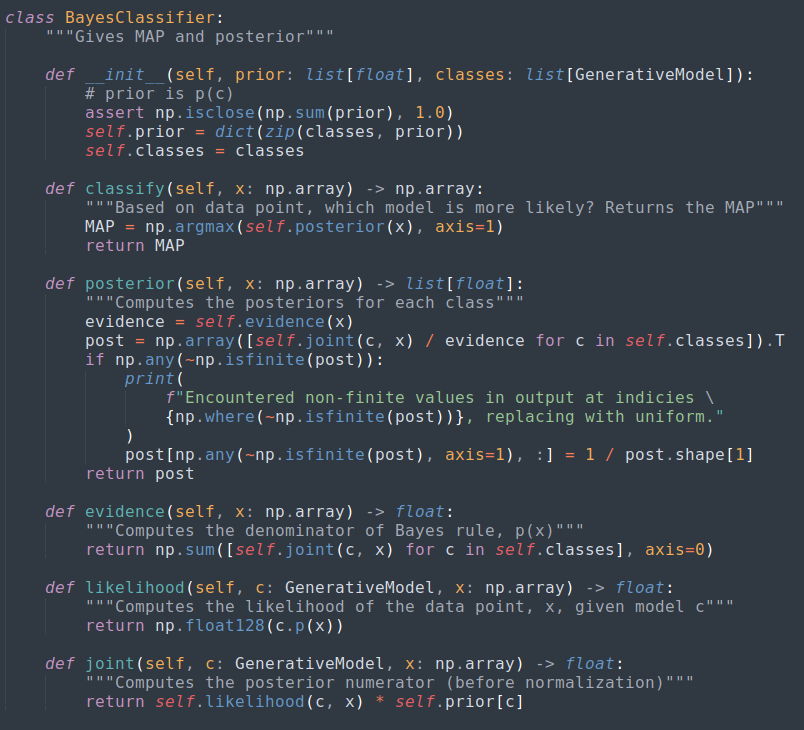

### Mini-Demonstration

In [3]:
d = 100

nominal = informed_classification.generative_models.NominalModel(d)
disrupted = informed_classification.generative_models.DisruptedModel(d)

prior = [0.5, 0.5]
bayes = informed_classification.bayes_classifier.BayesClassifier(
    prior, [nominal, disrupted]
)

n = 10000
nominal_data = nominal.sample(n)
disrupted_data = disrupted.sample(n)

nominal_pred = bayes.classify(nominal_data)
nominal_accuracy = np.sum(nominal_pred == 0) / n

disrupted_pred = bayes.classify(disrupted_data)
disrupted_accuracy = np.sum(disrupted_pred == 1) / n

print("Nominal Accuracy:", nominal_accuracy)
print("Disrupt Accuracy:", disrupted_accuracy)

Nominal Accuracy: 0.9989
Disrupt Accuracy: 0.9956


In the cell above, you can see a small demo of the Bayes Classifier. Using the underlying models -- Nominal and Disrupted -- as the bayes classifier on n=1000 (apiece) samples, we can see that even for this very ambiguous set of time series (where process A and B look very similar), the bayes classifier has very good accuracy. 

There is some interesting behavior to discuss with this smaller demonstration of the classifier.

In [4]:
print("Mean's Posterior:", bayes.posterior(disrupted.dist.mean))

Mean's Posterior: [9.99943270e-01 5.67299479e-05]


These two processes - Nominal and Disrupted - have identical mean functions, but yet the most likely sample from either of them (the mean function exactly) the model is almost 100% certain that it came from the Nominal model. I thought this might be a bug, but this is actually reasonable (and I suppose mathematically correct) behavior.

Since the disrupted model's covariance is larger and has more correlations with non-contiguous timesteps, we can consider the pdf of the distribution to be much wider spread. The height of the nominal pdf at the vector representing the mean is simply far, far taller than the disrupted's pdf.

In [5]:
print(
    "Ratio of PDF of mean vector for Nominal to Disrupted: ",
    nominal.p(disrupted.dist.mean) / disrupted.p(disrupted.dist.mean),
)

Ratio of PDF of mean vector for Nominal to Disrupted:  17626.373848097777


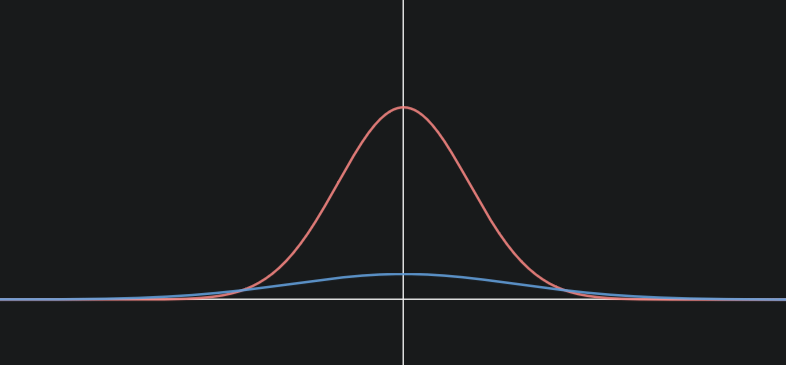\
***Figure: A Gaussian with high variance centered at zero over a gaussian with a tight variance centered at zero.***

## Fitted Gaussians

See the associated file [here!](https://github.com/JuLieAlgebra/informed_classifier/blob/main/informed_classification/models.py)

### FittedGaussianModel
The FittedGaussianModel class is designed to fit both the mean vector and covariance matrix of input data, under the assumption that the underlying process is a Gaussian Process (GP) or a Multivariate Normal distribution.

Detailed Overview:
- Initialization `(__init__)`: The constructor takes an array of data (assumed to be formatted as (n_samples, time_dimension) without labels) and computes the mean vector and covariance matrix using the Maximum Likelihood Estimation (MLE) method. The allow_singular parameter is set to False in the ss.multivariate_normal distribution, ensuring that the fitted covariance matrix is non-singular.
- MLE Method (`mle`): This method computes the mean vector and covariance matrix from the input data. If the data has only one sample, a zero matrix is returned as covariance; otherwise, np.cov is used. The covariance matrix is regularized to be non-singular by the `regularize_singular_cov` function. Please see the `Challenges Encountered` section for more about why that was necessary.
- Probability Density Function (`p`): Calculates the probability density of a given input array x using the fitted Gaussian distribution.
- Sampling (`sample`): Generates samples from the fitted Gaussian distribution.
- Plot Method (`plot`): Creates a plot showing the heatmap of the covariance matrix, sample trajectories, and the fitted mean function. The number of samples plotted can be specified.
  
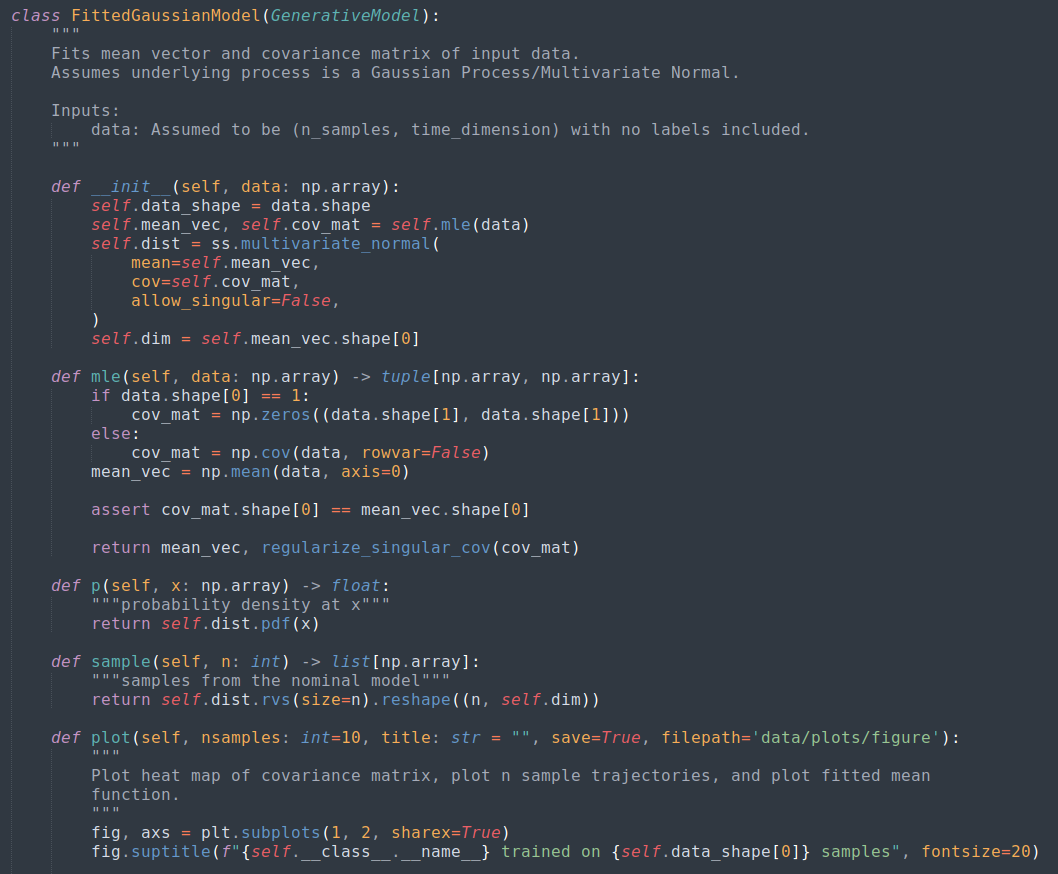
I cut off the plot function since it's both long and not important to the discussion here.

### FittedMeanGaussianModel
The FittedMeanGaussianModel class is a specialized version of the FittedGaussianModel. It fits only the mean vector of the input data and utilizes a known covariance matrix from either a nominal or disrupted Gaussian Process.

Detailed Overview:
- Initialization (`__init__`): The constructor accepts the data and a process_type ('nominal' or 'disrupted'). It computes the mean vector using MLE and uses the known covariance matrix associated with the specified process type.
- MLE Method (`mle`): Calculates the mean vector from the input data.



### FittedCovGaussianModel
The FittedCovGaussianModel is another specialized version of the FittedGaussianModel. It focuses on fitting the covariance matrix of the input data while using a known mean vector from either a nominal or disrupted Gaussian Process.

Functionality:
- Initialization (`__init__`): Similar to FittedMeanGaussianModel, but this class fits the covariance matrix and uses a known mean vector from the specified process type.
- MLE Method (`mle`): Calculates the covariance matrix from the input data.



Sample trajectories from models fitted on 1


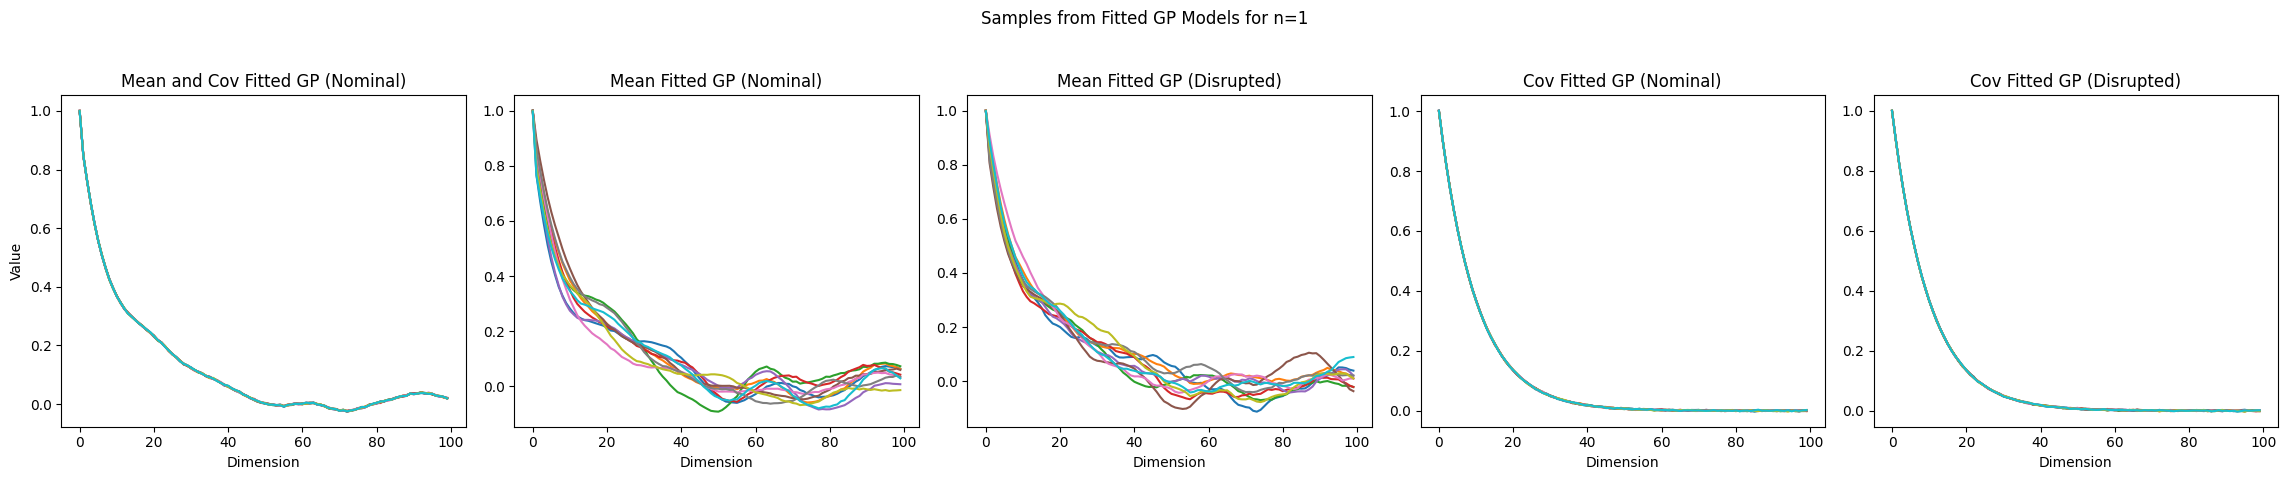

Sample trajectories from models fitted on 3


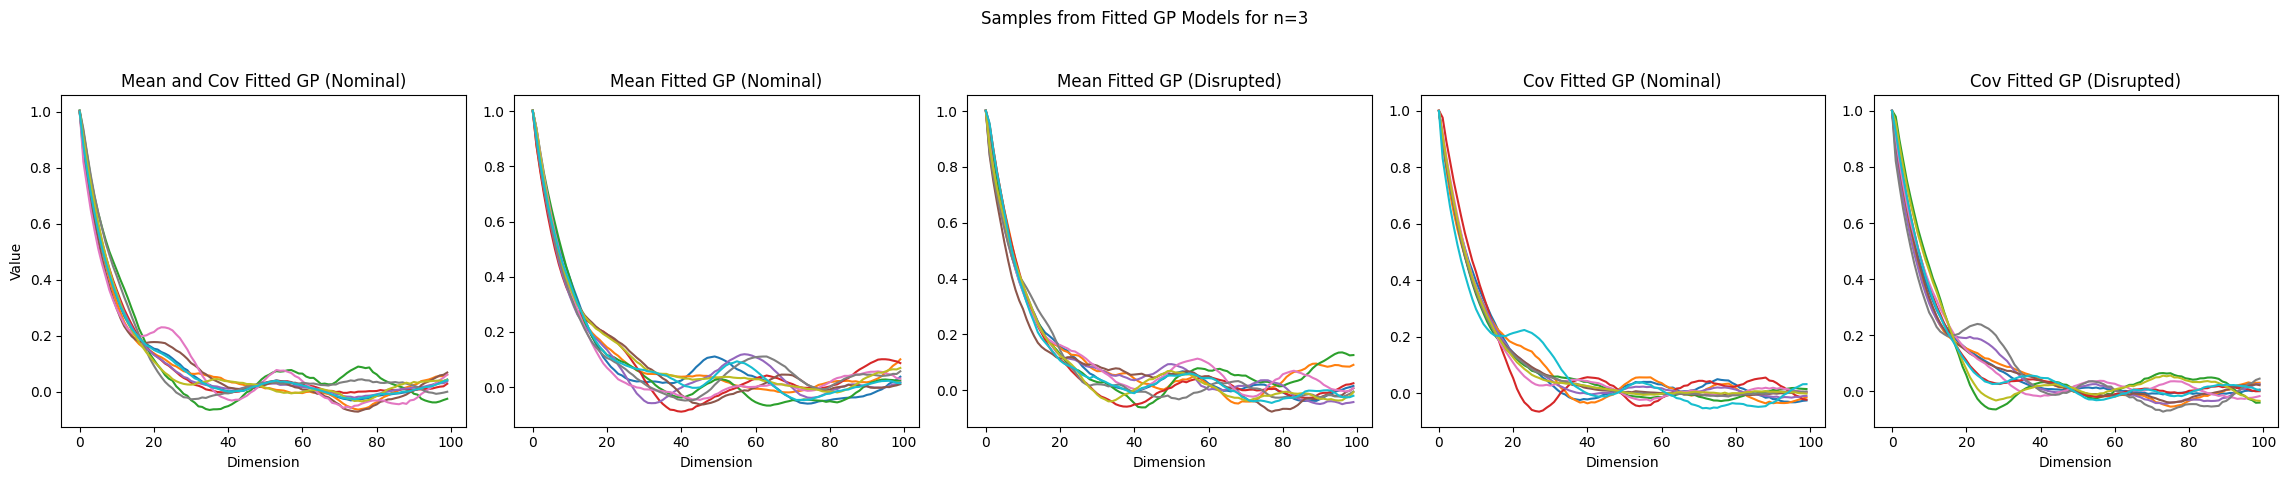

Sample trajectories from models fitted on 5


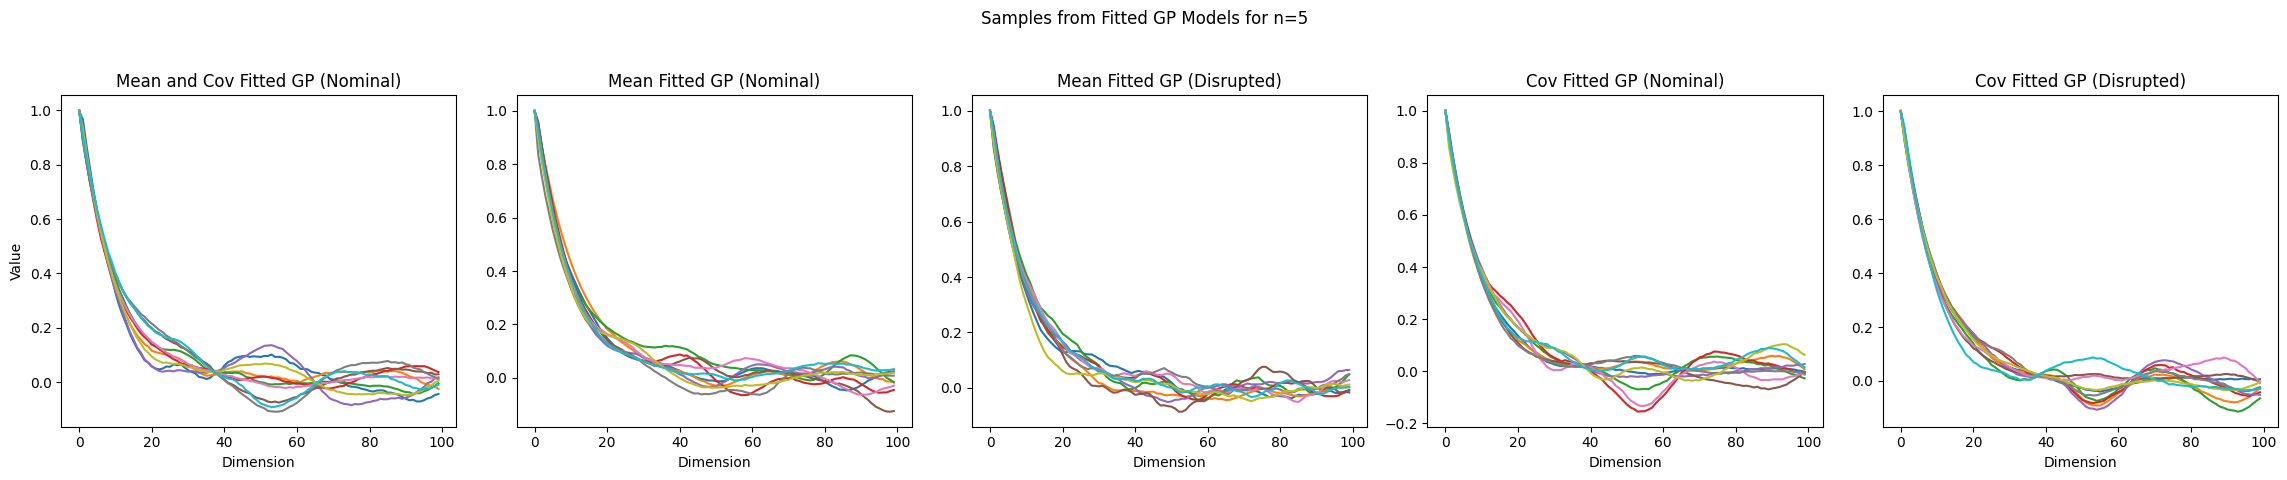

Sample trajectories from models fitted on 7


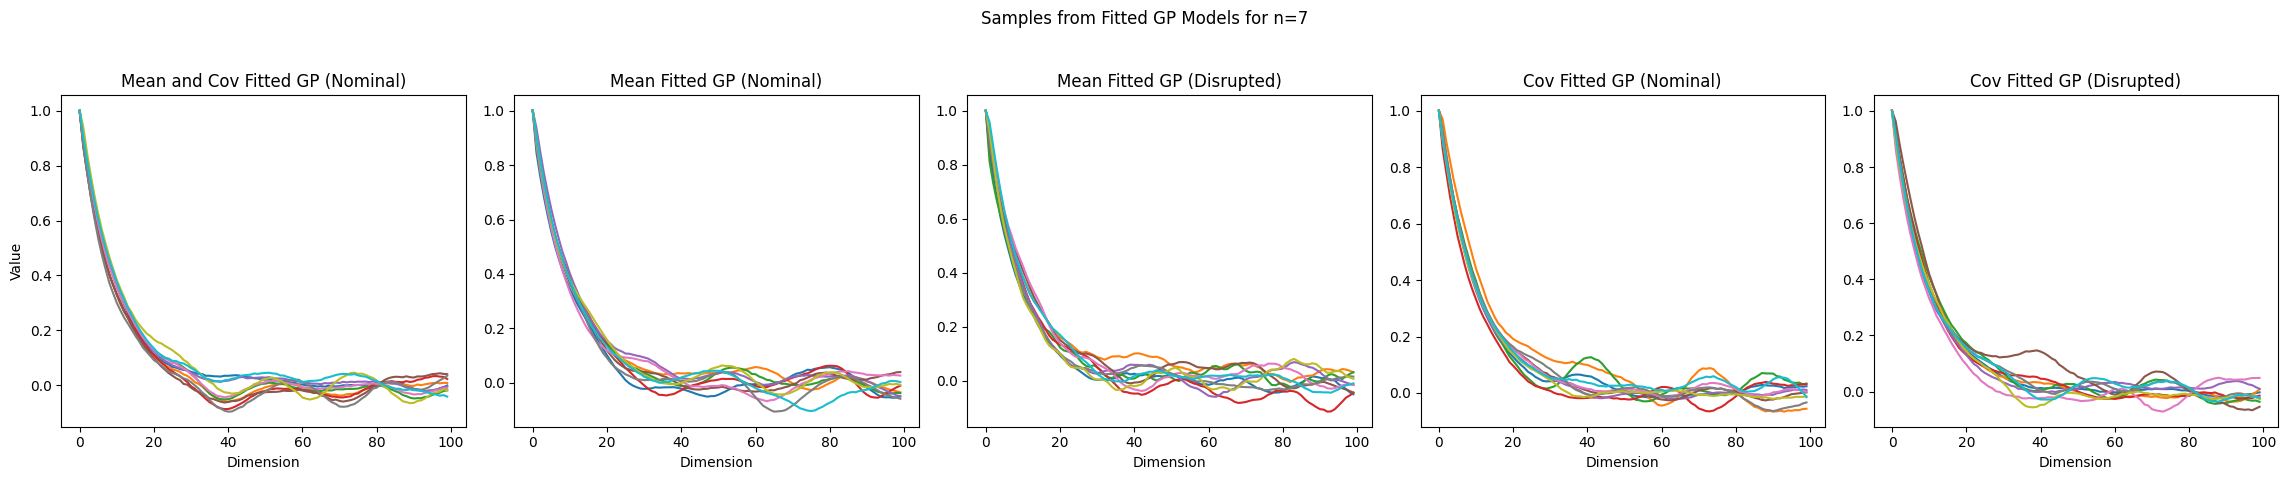

Sample trajectories from models fitted on 9


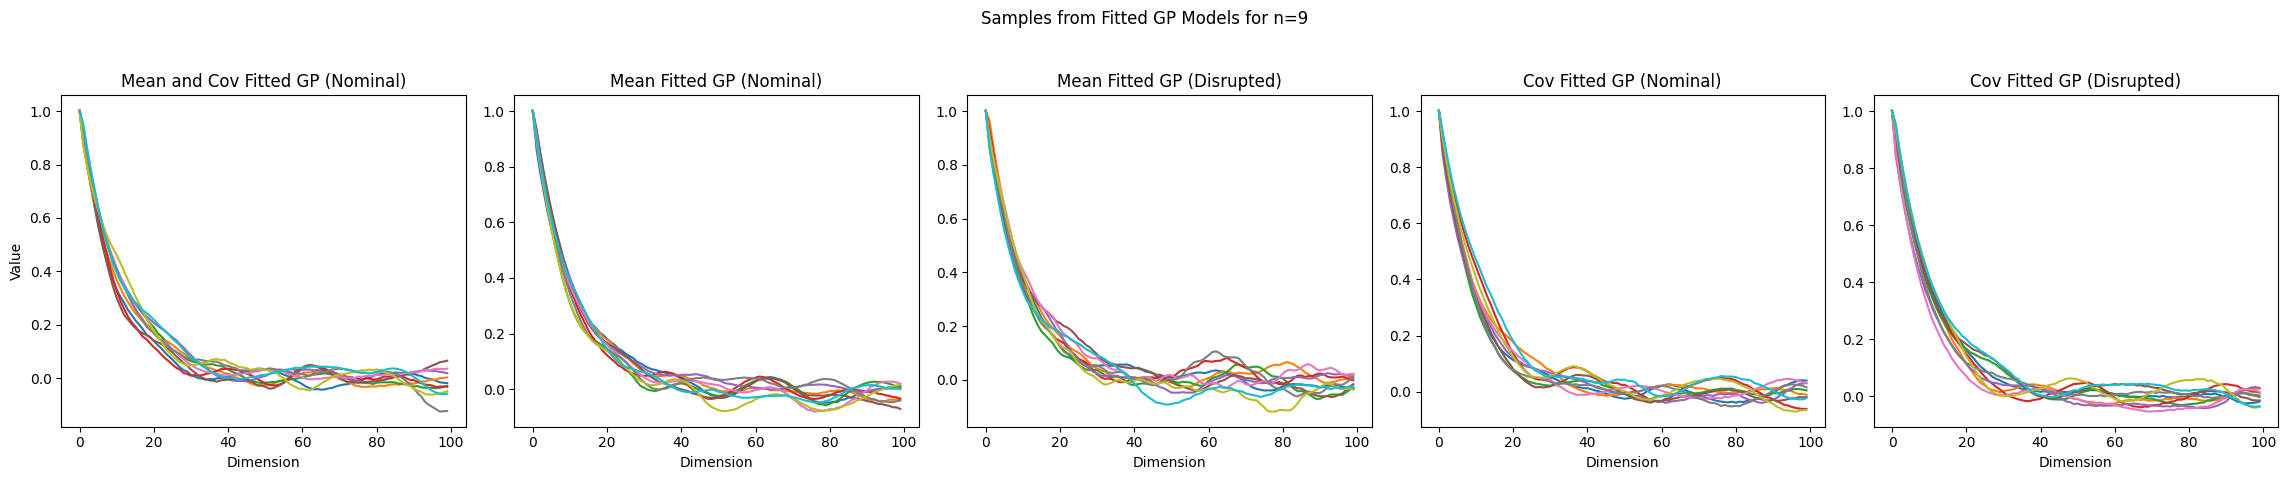

In [13]:
# Sorry for the non-module preserving imports!
from informed_classification.models import (
    FittedCovGaussianModel,
    FittedMeanGaussianModel,
    FittedGaussianModel,
)
from informed_classification.generative_models import NominalModel, DisruptedModel

dim = 100
n_samples = np.arange(1, 10, step=2)
for n in n_samples:
    print(f"Sample trajectories from models fitted on {n}")
    underlying_model = NominalModel(dim=dim)
    data = underlying_model.sample(n)

    model = FittedGaussianModel(data=data)
    mean_nominal_model = FittedMeanGaussianModel(data=data, process_type="nominal")
    mean_disrupted_model = FittedMeanGaussianModel(data=data, process_type="disrupted")
    cov_nominal_model = FittedCovGaussianModel(data=data, process_type="nominal")
    cov_disrupted_model = FittedCovGaussianModel(data=data, process_type="disrupted")

    models = [
        model,
        mean_nominal_model,
        mean_disrupted_model,
        cov_nominal_model,
        cov_disrupted_model,
    ]
    for m in models:
        m.plot(nsamples=5)

    ## Plotting the results
    fig, axes = plt.subplots(1, 5, figsize=(23, 5))
    fig.suptitle(f"Samples from Fitted GP Models for n={n}")

    # FittedGaussianModel
    axes[0].plot(model.sample(10).T)
    axes[0].set_title("Mean and Cov Fitted GP (Nominal)")
    axes[0].set_xlabel("Dimension")
    axes[0].set_ylabel("Value")

    # FittedMeanGaussianModel (Nominal)
    axes[1].plot(mean_nominal_model.sample(10).T)
    axes[1].set_title("Mean Fitted GP (Nominal)")
    axes[1].set_xlabel("Dimension")

    # FittedMeanGaussianModel (Disrupted)
    axes[2].plot(mean_disrupted_model.sample(10).T)
    axes[2].set_title("Mean Fitted GP (Disrupted)")
    axes[2].set_xlabel("Dimension")

    # FittedCovGaussianModel (Nominal)
    axes[3].plot(cov_nominal_model.sample(10).T)
    axes[3].set_title("Cov Fitted GP (Nominal)")
    axes[3].set_xlabel("Dimension")

    # FittedCovGaussianModel (Disrupted)
    axes[4].plot(cov_disrupted_model.sample(10).T)
    axes[4].set_title("Cov Fitted GP (Disrupted)")
    axes[4].set_xlabel("Dimension")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

You can see that for Gaussian Processes that did not have to estimate the covariance matrix (only the 2nd and 3rd columns), training on only one sample and then sampling from that model still contains variance in those trajectories, because they were using the covariance matrix of the associated underlying process.

There was special logic added to these classes so if they were asked to fit a covariance matrix to input data that only contained one trajectory, they would return zero covariance (instead of throwing an error). I thought this would be a good illustration for the model's behavior to start from only one sample (and a good sanity check).

You can see that over time, for both the nominal and disrupted models, even for as few training points as 9, we get realistic looking sample trajectories from the fitted models. This, however, does not mean it would perform well at its classification job for so few datapoints! We'll see those results in the later sections.

Note that most of these estimated covariance matrices are singular for so few data points, so we project the covariance matrix to something "almost singular" instead, but we will discuss the details and justification for that in later sections as well. We can, however, sample from singular (and of course almost singular) Gaussian Processes!


## Baseline Discriminative Model: SVM
As our representation of a discriminative approach that assumes nothing about the underlying data, other than the ones imposed by the model, we have a Support Vector Machine. I used an off-the-shelf one from scikit-learn with a radial basis function kernel. We know from the covariance matrix inspection that this kernel aligns with the Nominal model's covariance function (which is approximately an RBF), but this wouldn't hold for the disrupted model.

The data wasn't initially scaled and the performance was terrible (below 0.52 accuracy for even the largest dataset sizes). After implementing standard scaling for the X data, the model, of course, did significantly better. However, the performance was still quite bad, for reasons we'll discuss in later sections.

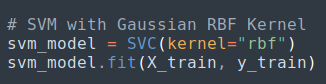

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# At least if I'm importing things without their module names, you'll be able to see where they're coming from at the beginning of the cell
from informed_classification.common_utilities import get_config, load_data
from informed_classification.analysis import evaluate_svm_model

## This would normally be processed automatically from the CLI config parameter that points to a YAML config file
config = {
    "dim": 100,
    "disrupted_version": 2.0,
    "nominal_version": 2.0,
    "ratio": 0.5,
    "samples": 10000,
    "train_test_validation_split": [0.01, 0.89, 0.1],
    "experiment_name": "100dim_10000samples_0_5ratio_0_01train_0_89test_0_1val_2_0nom_2_0dis",
}

# Load datasets from their respective sections
train_data = load_data(f"data/{config['experiment_name']}/train")
test_data = load_data(f"data/{config['experiment_name']}/test")
validation_data = load_data(f"data/{config['experiment_name']}/validation")

# Split features and labels from the loaded data
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]
X_val, y_val = validation_data[:, :-1], validation_data[:, -1]

# Fitting and applying dataset scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# SVM with Gaussian RBF Kernel
svm_model = SVC(kernel="rbf")
svm_model.fit(X_train_scaled, y_train)

# Evaluating SVM model on Train, Test, and Validation sets
train_metrics, y_train_pred = evaluate_svm_model(
    svm_model, X_train_scaled, y_train, "Train Set"
)
test_metrics, y_test_pred = evaluate_svm_model(
    svm_model, X_test_scaled, y_test, "Test Set"
)
val_metrics, y_val_pred = evaluate_svm_model(
    svm_model, X_val_scaled, y_val, "Validation Set"
)

Metrics for Train Set:
Accuracy: 0.89
Precision: 0.97
Recall: 0.79
F1 Score: 0.87
Metrics for Test Set:
Accuracy: 0.54
Precision: 0.54
Recall: 0.47
F1 Score: 0.51
Metrics for Validation Set:
Accuracy: 0.51
Precision: 0.52
Recall: 0.45
F1 Score: 0.48


This is just a small demo for 100 training data points, which is pretty small, but you can see that the SVM is struggling to generatize to the testing and validation sets.

### Metrics
I tracked metrics suitable for a classification task -- precision, recall, accuracy, and the f1 score. The variance in the boxplots you see are the results of those scores across the 5 k-fold splits of the training data.
Despite talking about time series and fitting to them, there is no real notion of "residuals" here, as the models are not predictive, but generative.

## Bayes Classifier with True, Underlying Distributions
These are the confusion matrices for the Bayes classifier that uses the true Nominal and Disrupted distributions for the classification. As we know should be true, it outperforms all other models and has consistent high performance with only a few samples getting misclassified, which sets the bar pretty high for the minimum possible error rate. 

Since the model is not trained, these results are over the entire testing and validation sets and have no variation over "training size".
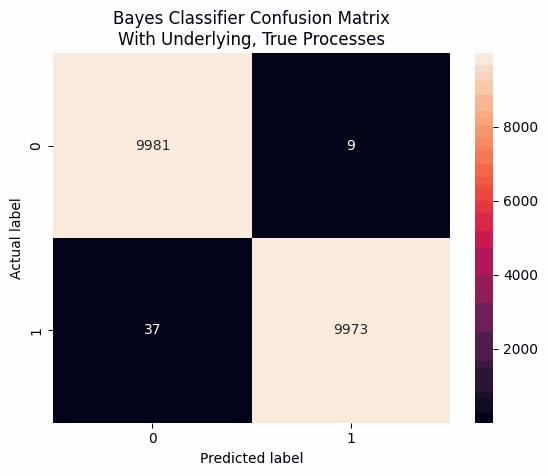

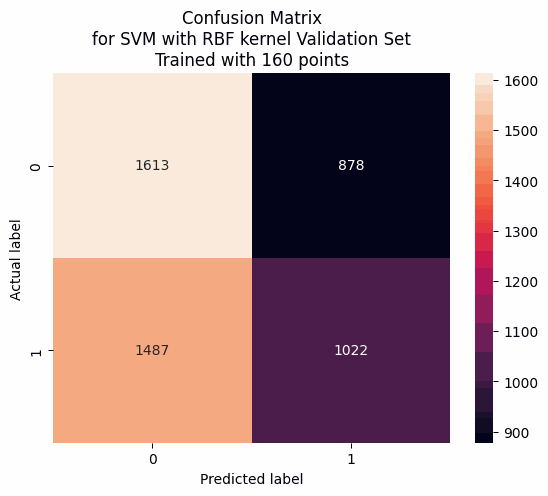

This train dataset was still split up into five sections, so this is the result of the model over all five:

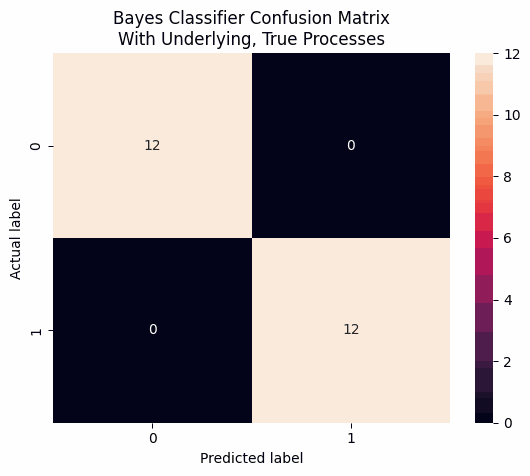

## Fitted Mean, Cov Gaussian Process Results
These are the results from fitting two Gaussian Processes (both mean and covariance) and using the correct prior of [0.5, 0.5] for the Bayes classifier. We could have estimated this prior from the ratio of the samples in the training set as well.

Below are gifs of the confusion matrices for the Bayes classifier (for fitting all parameters of process A and B) over the number of training points. We'll see more plots that illustrate the performance over training set size in the next section, but hopefully this gives another good picture of what the model is learning -- and how fast!


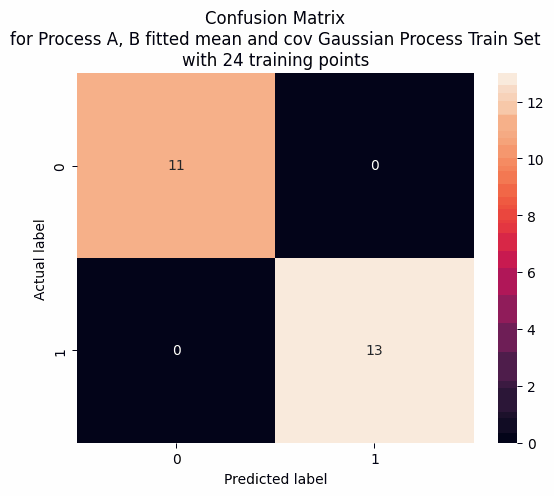

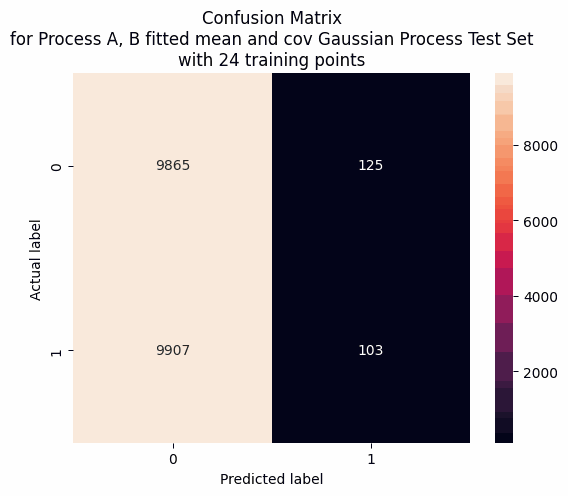

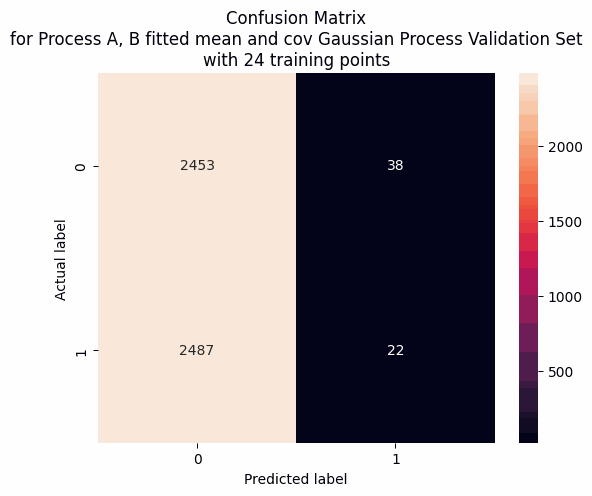

The training set sizes start off smaller than the SVM gifs below, but the model converges quickly and performs very well after under a 100 training samples!

## SVM Confusion Matrices

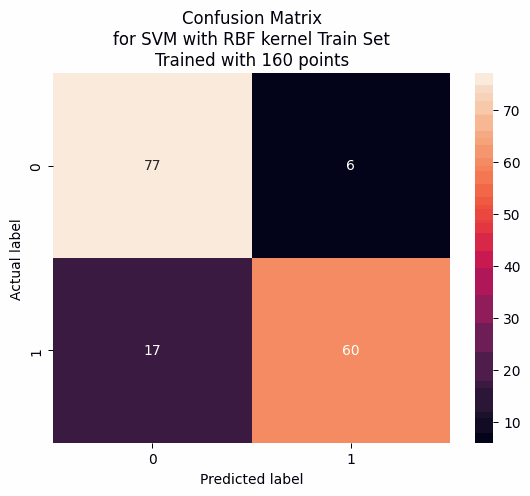

And if you think the training data looks pretty bad ...

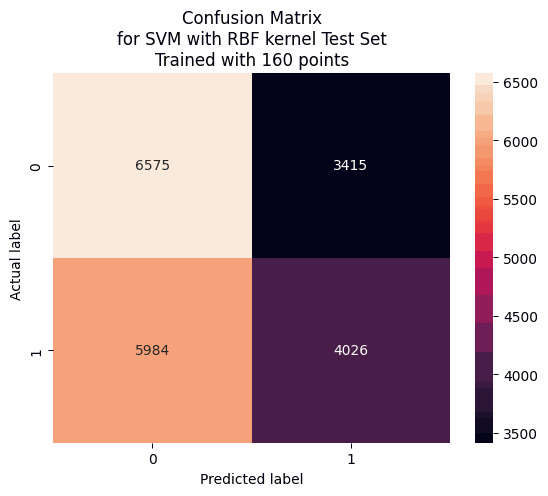

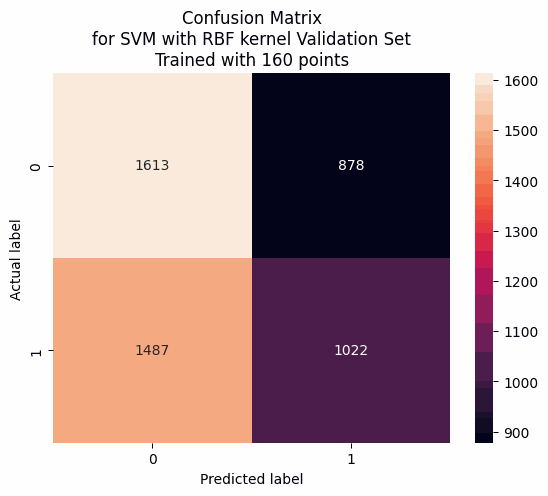

We're going to talk about the results of the SVM in more detail later, but you can see how the model struggles to classify the data well, even for the largest training sets. I believe this is because the process distributions are on top of each other, with no clear way to draw a boundary between them. The difference in time correlations and higher variance in Process B (disrupted) isn't enough for the SVM to find something that generalizes well!

# Boxplots of Metrics over Training Set Sizes

## Calculating Performance
Calculate average performance of each model on different size datasets. 
Do this by generating a large dataset, then for each desired dataset size, collect the performance metrics across k-fold validation.

Examining the performance of these models in very low-data regimes can be tricky. For n=10 training samples, fitting the mean and cov function of Process A & B saw testing (8,000) and validation (1,000) set accuracies from 90% to 61%, depending on which ten generated trajectories the models were allowed to train on. This emphasized the need for gauging the *average* and *median* accuracies for testing & validation, across a large number of repeated low-data trainings.

For this reason, there is a "double sweep" over two parameters - five (k-fold) splits of the training data and the overall training set size. First the training set size parameter determines the size of the slice we'll take from the training data, then the remaining data is split. 

The sample_size numbers you'll see in the plots, however, is the number of data points the model had access to (after the k-fold splitting). Note that since the data is shuffled before splitting into the train/test/val splits, there is not an equal number of process A and process B examples passed to each model. For that reason, you'll see that the sample sizes passed to the fitted Gaussian Processes will not always be a multiple of ten.

You can see the definitions of these box plots (and most other figures) here: https://github.com/JuLieAlgebra/informed_classifier/blob/main/informed_classification/analysis.py
The metrics themselves are calculated in associated `scripts/evaluate_kfold_{model name here}.py`.

### Why are there no boxplots of GP models representing different amounts of prior knowledge?
**Note**: You won't see results of performing the original "prior knowledge" sweep that I proposed in the project proposal. While I was developing this, I wrote the model that fit the mean and covariance for both processes first and was incredibly surprised to see how well this model performed. It dramatically outclasses the SVM and very rapidly approaches the theoretical maximum accuracies (Bayes classification using the underlying processes). Since this sweep was meant to identify where the discriminative model would outperform modeling the generative processes, I decided to focus my attention on what would be **more** interesting. 

Since the other situations I proposed doing first would only outperform having to esimate the covariance and mean of both processes, I stuck with the FittedGaussianModel (fits both mean and cov) and experimented with the more interesting question: How much less data does the informed-classifier approach need than the discriminative approach to reach the same accuracies?

The answer to that question will continue to be explore in the following boxplots as we map the performance metrics for different training set sizes.

## Claim: Variance in the Boxplots is due to the Training Set Variance
**Additional Note**: I claim that the variance in the boxplots is due to the random sample of training data we get at each k-fold split, instead of the inherent uncertainty in accuracy measurements (are you measuring the accuracy of a biased testing set). The testing set for the results is very large (>10k), so I feel comfortable saying that there's little uncertainty in the testing set measuring accuracy (that's kind of a wordy sentence, sorry). 

# Setting the Stage: Performance of Bayes Classifier with True Distributions
Since we know that the Bayes classifier with the correct likelihoods and priors is the optimal classifier (in regards to risk), let's first look at the results of using the ground truth models on the datasets. This is still a k-fold sweep of different dataset sizes, but there is no training involved. We should see consistent, horizontal lines across the datasets, with some variation due to noise and unlikely sampled data (think about the importance of false positive rates for hypothesis tests! For an alpha=0.05, we should expect to reject the null 5% of the time. We're sampling quite a lot of data as we go up in size, we're bound to see some very unlikely data points from both the disrupted and nominal models.)

These are the results of the model on the large (>10k) test set.

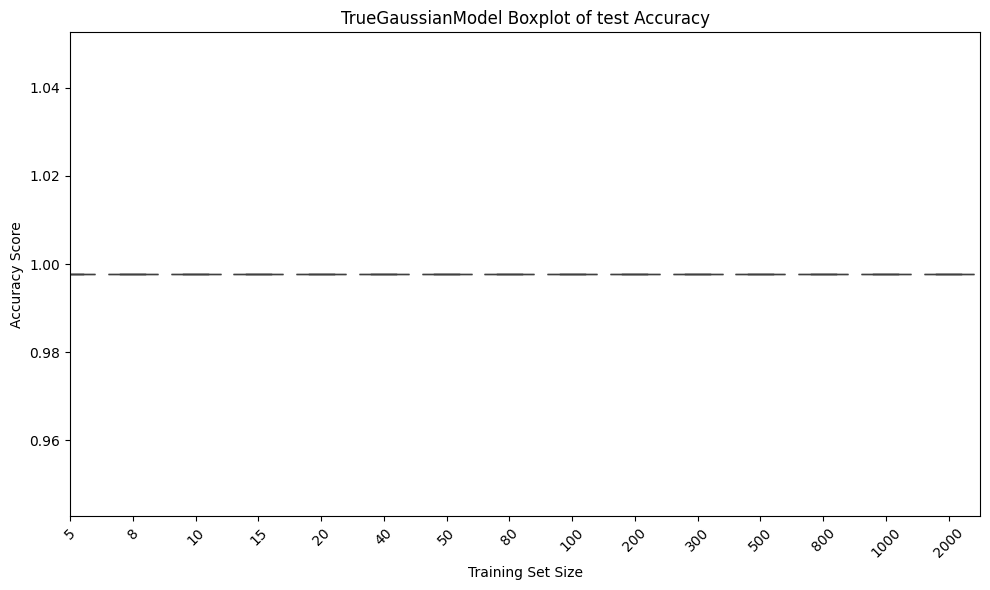

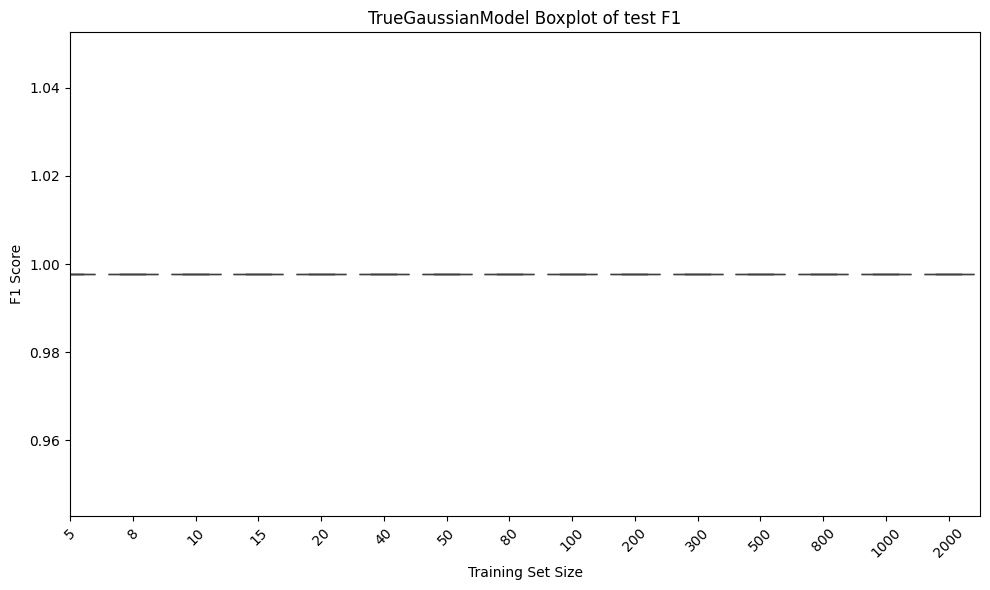

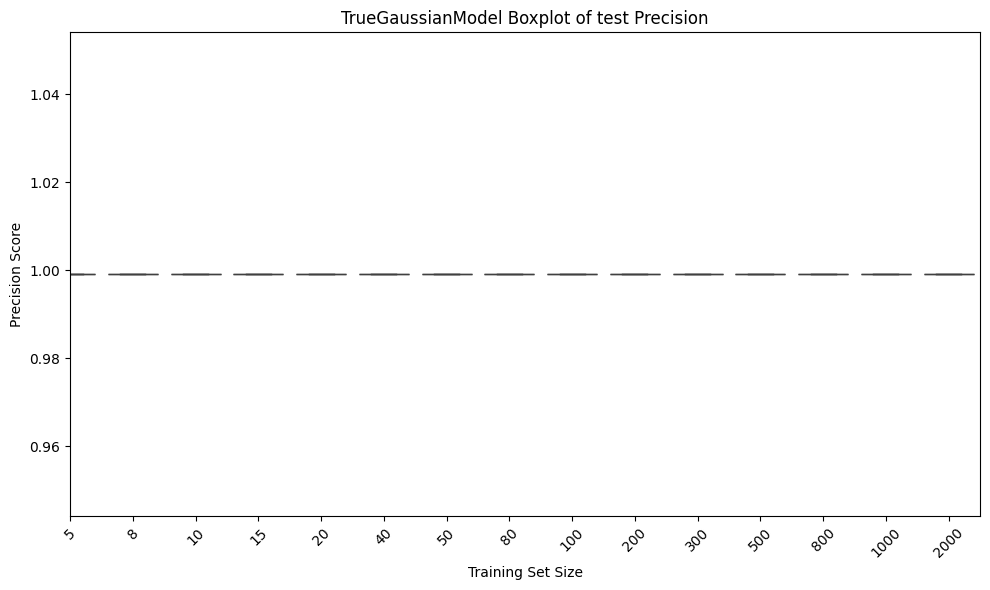

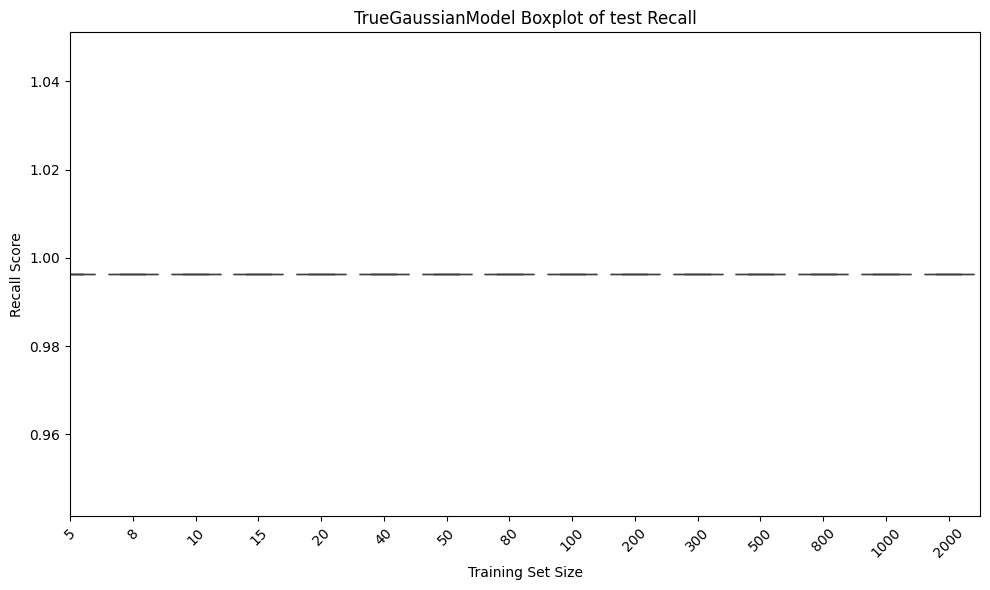

Sorry about the y-limits on those plots! It's a little tricky to parse, due to that, but the model has *almost* 100% on every metric for most of the sample sizes. 

Here's a look at the "training set" (since there is no training here):\
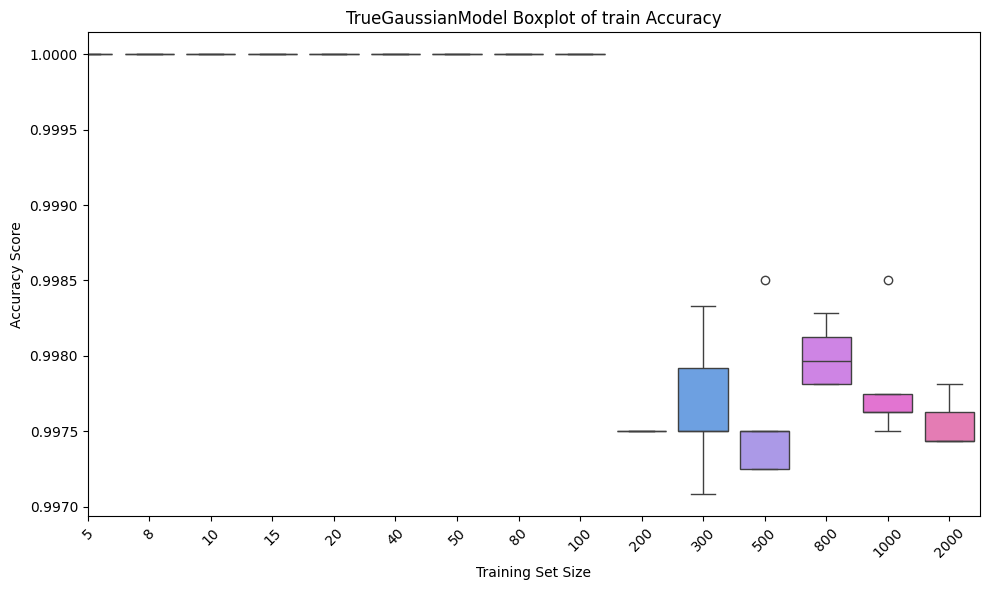

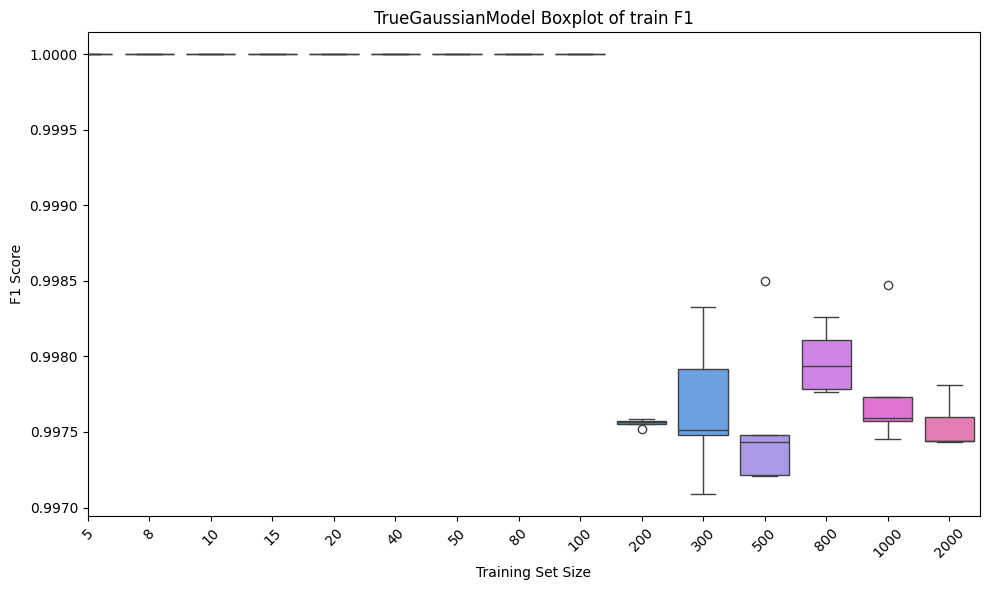

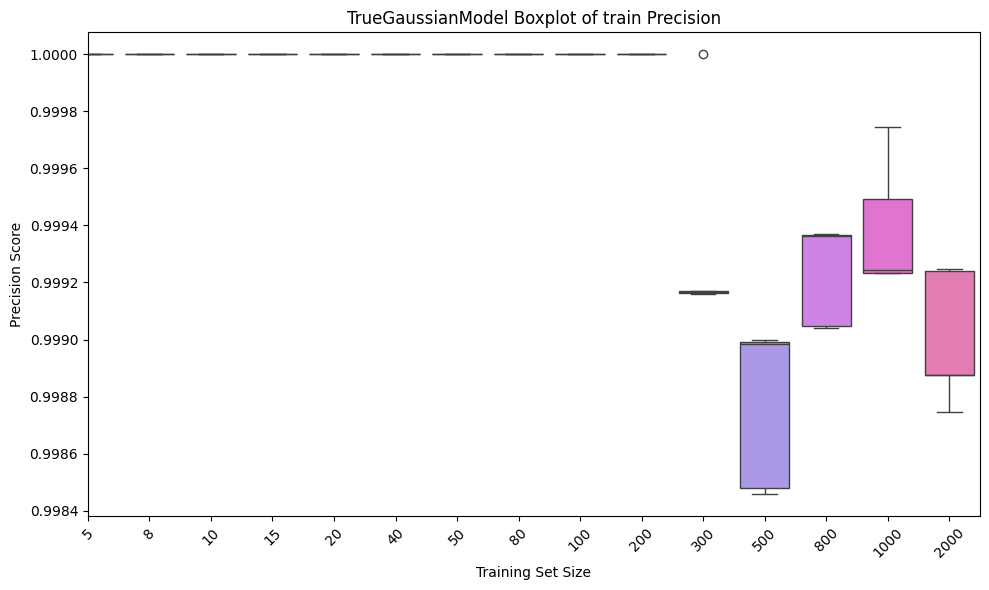

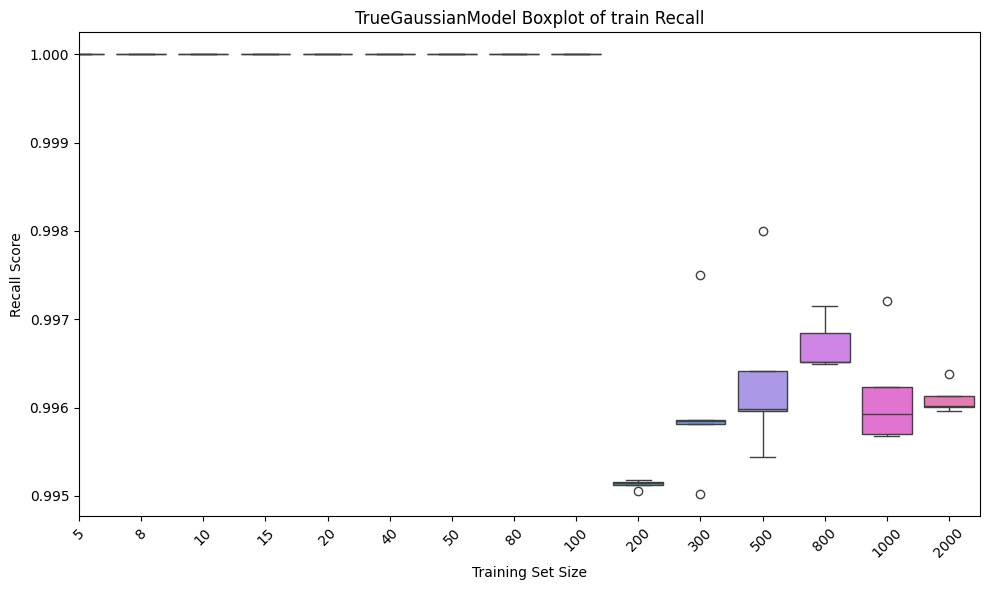

There is something **weird looking about the dips in model performance** over the data set size, but this is unfortunately due to how I partitiion the training. The data is shuffled once, but the initial slice of the dataset for the smaller training set size always goes like this `train_data[:training_data_size]`, so the first samples are always in the training data. After 200 samples, the performance drop looks **massive** and the data points that cause that first drop are simply not present in the smaller training set sections and are always present in training data sizes > 200.

***However***, it's important to note that the y-limits show us just how incredibly small that drop in performance is! We go from 100% on almost every metric every time to approximately 99.98% on every metric. That's likely just a few data points that's tripping the true bayes classifier up!  

### Fitted Bayes Classifier

For these two fitted process models (that compose a "Fitted Bayes Classifier"), we should see a steady increase in accuracy as the training set sizes increases, with an asympote hopefully at the theoretical best (Bayes with the true distributions). If we didn't see performance asymptoting around the theorical best, this would actually raise an eyebrow, because the mean and covariance estimators we're using are consistent estimators.

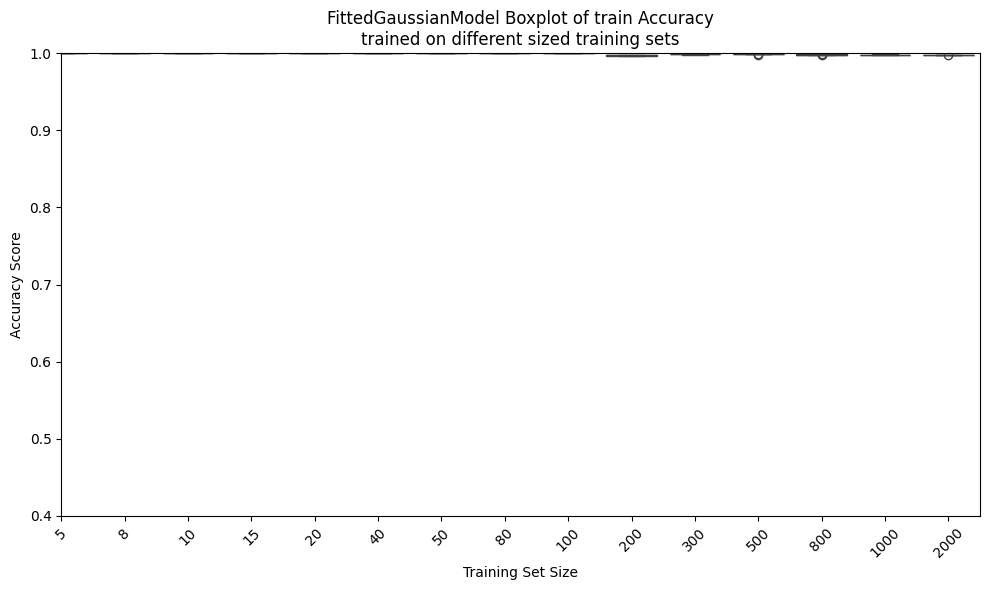

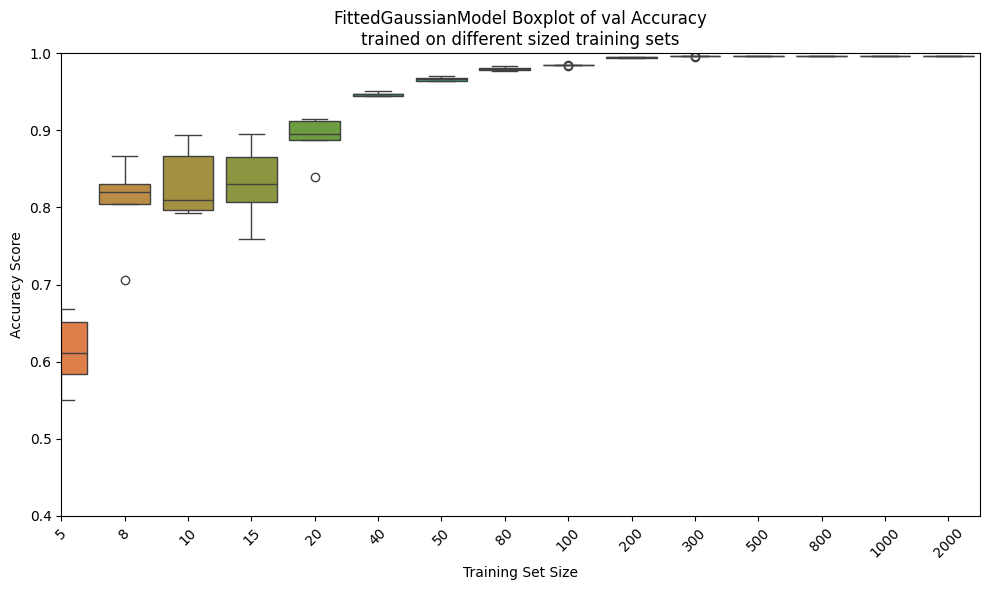

#### F1 Score

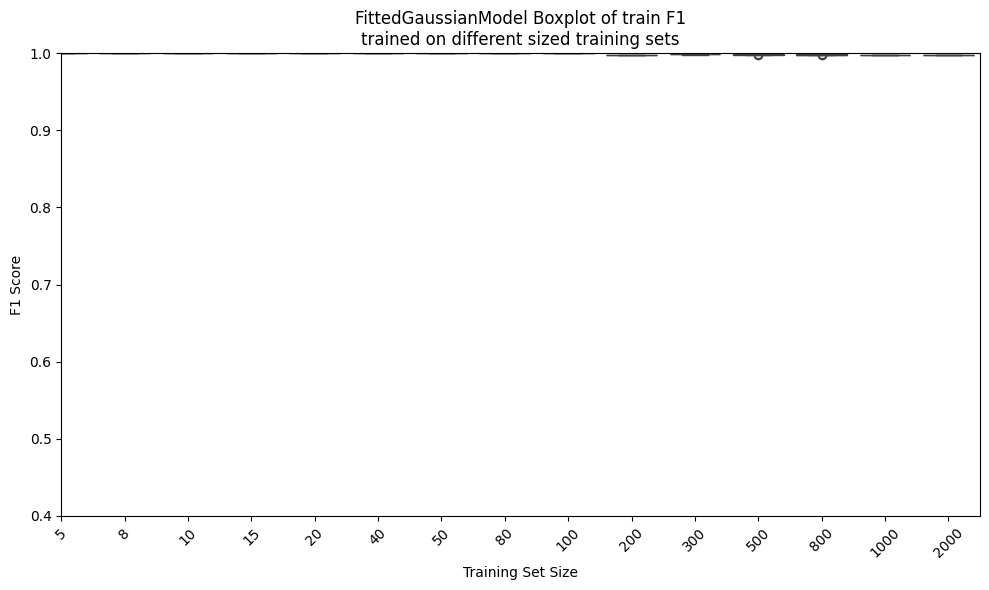

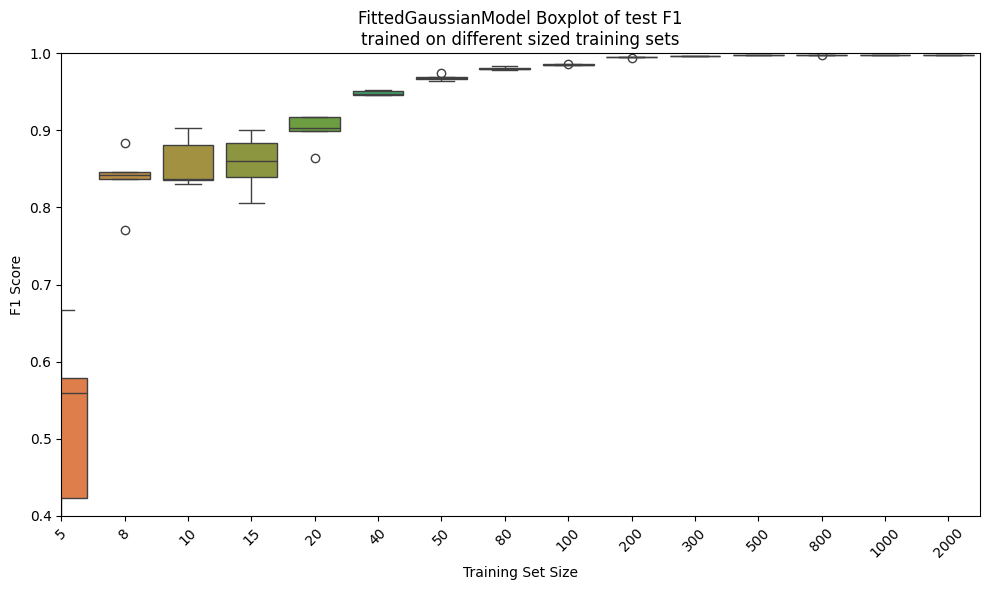

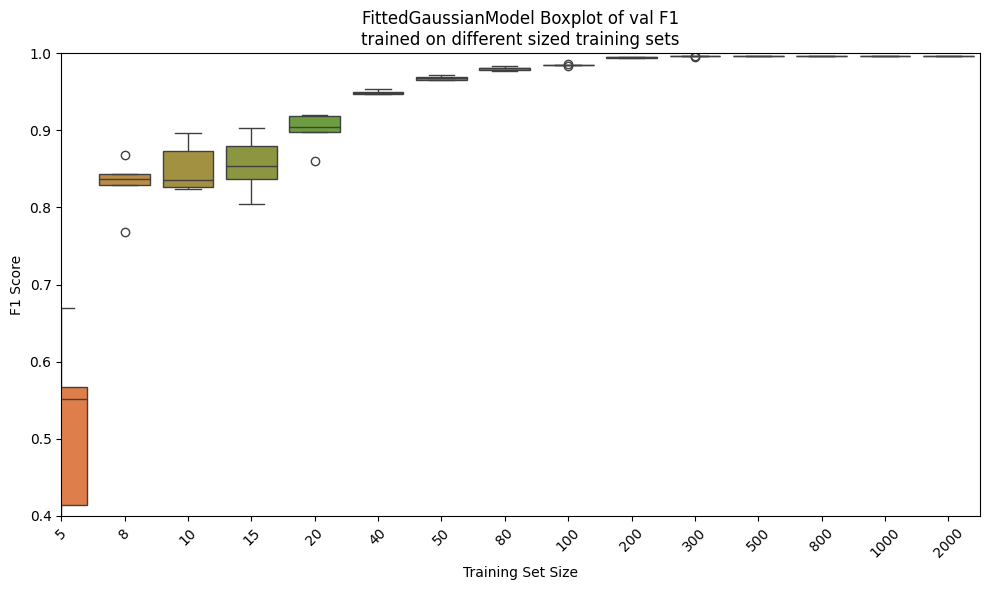

#### Precision
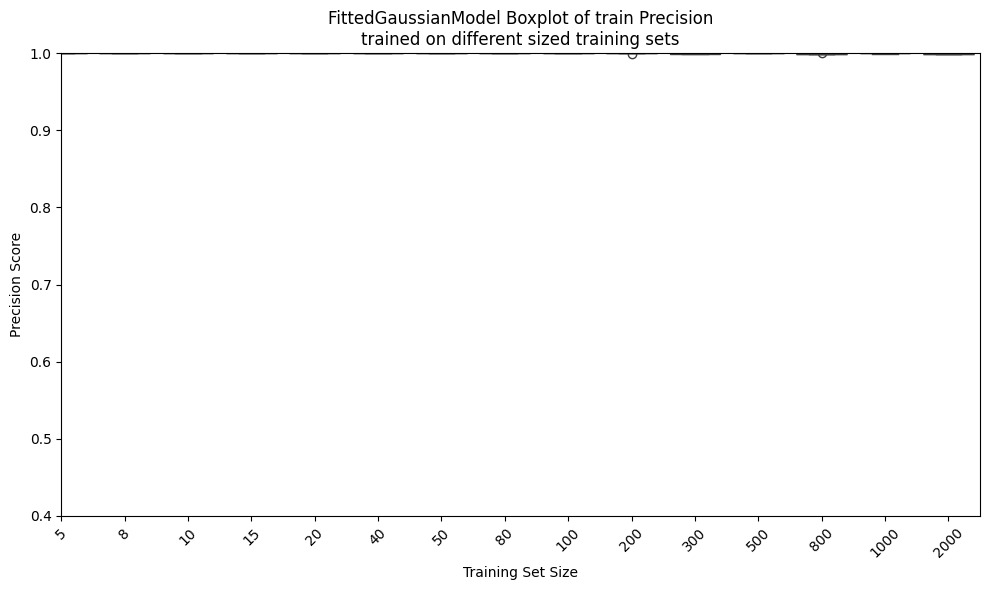

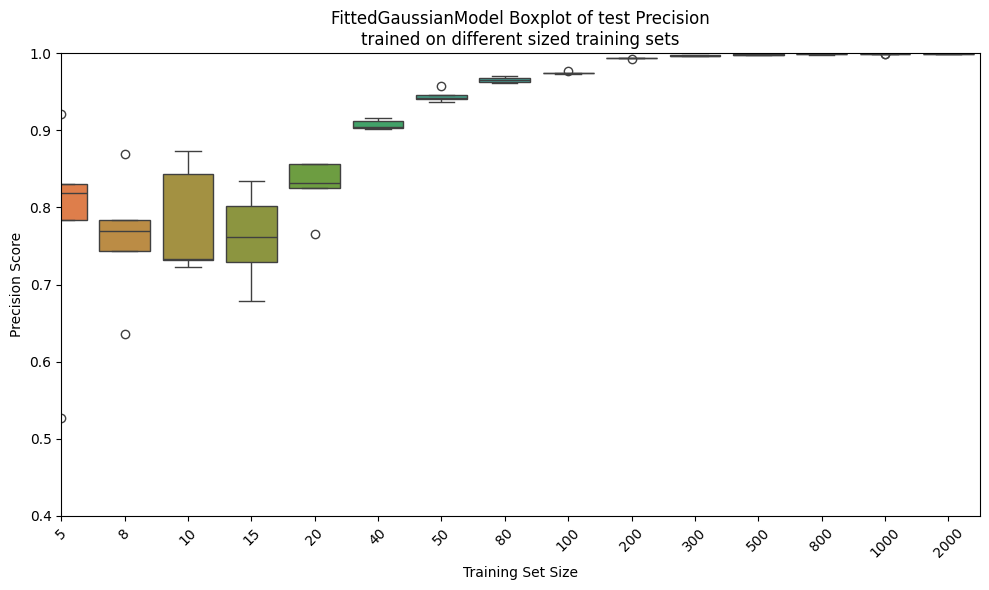

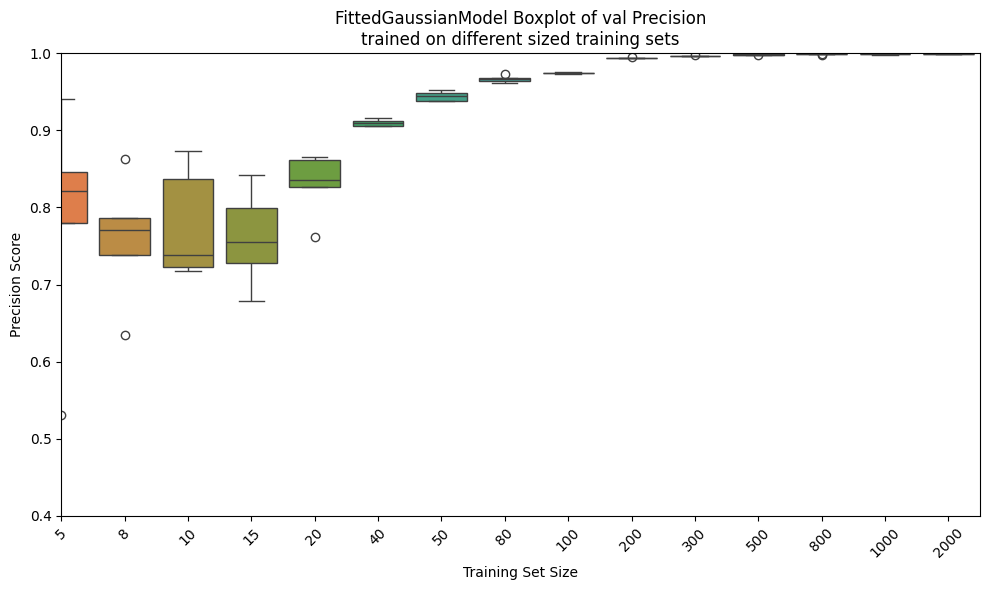

#### Recall
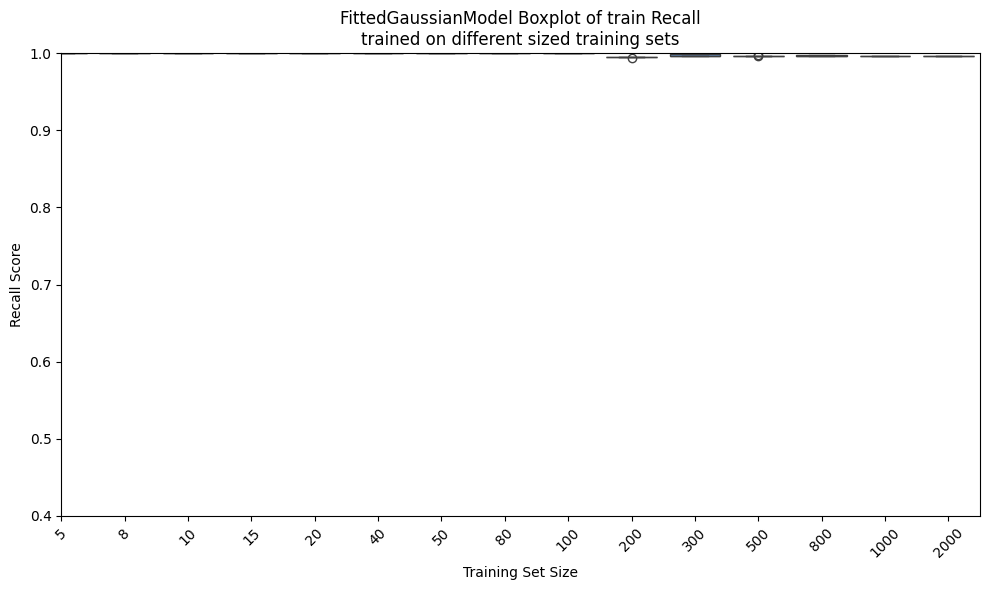

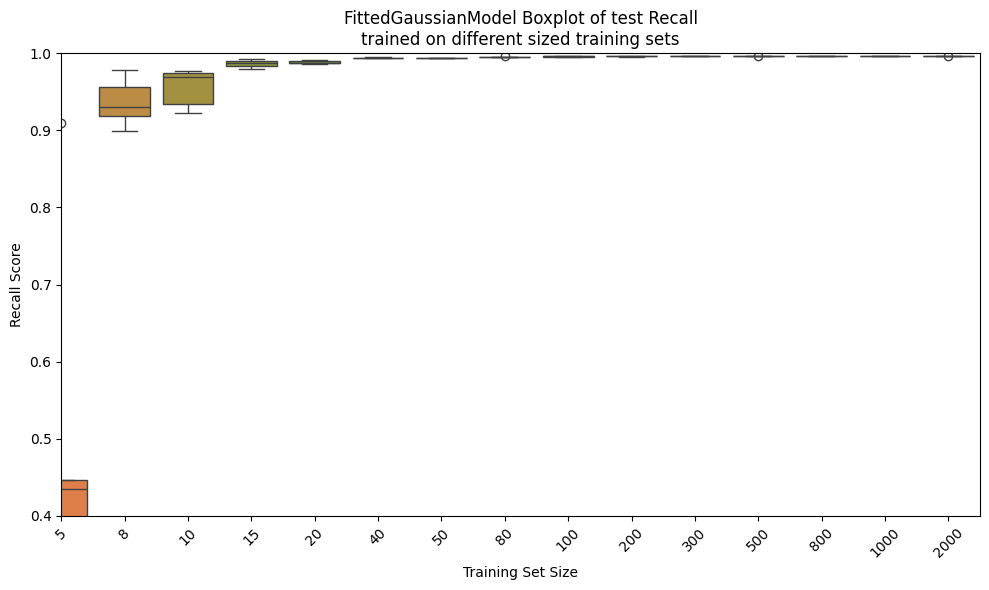

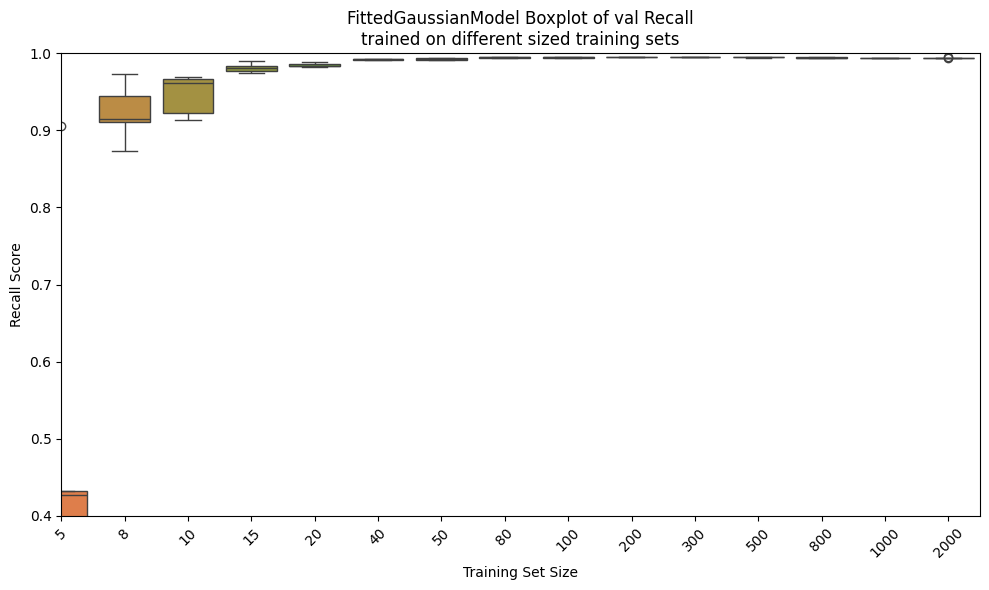

And we see what we expect! There's some variance due to noisy data, but we have a pretty good look at the distribution of model performance on different training set sizes. Reminder that the box plots are computed across the distibution of the 5 samples we get of that metric at that training set size, due to the k-fold data split. 


### SVM

These results are over the testing set!
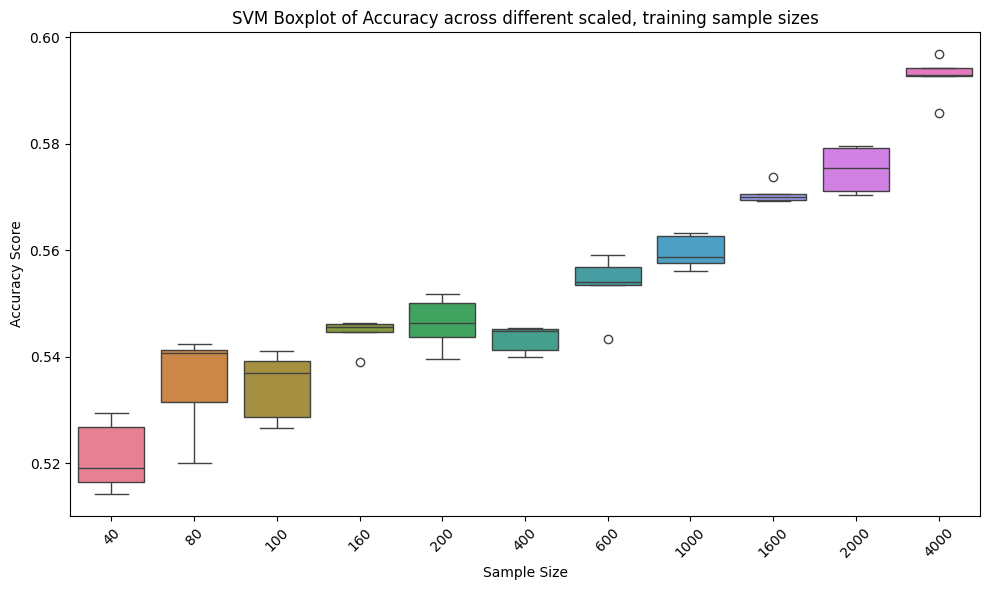\
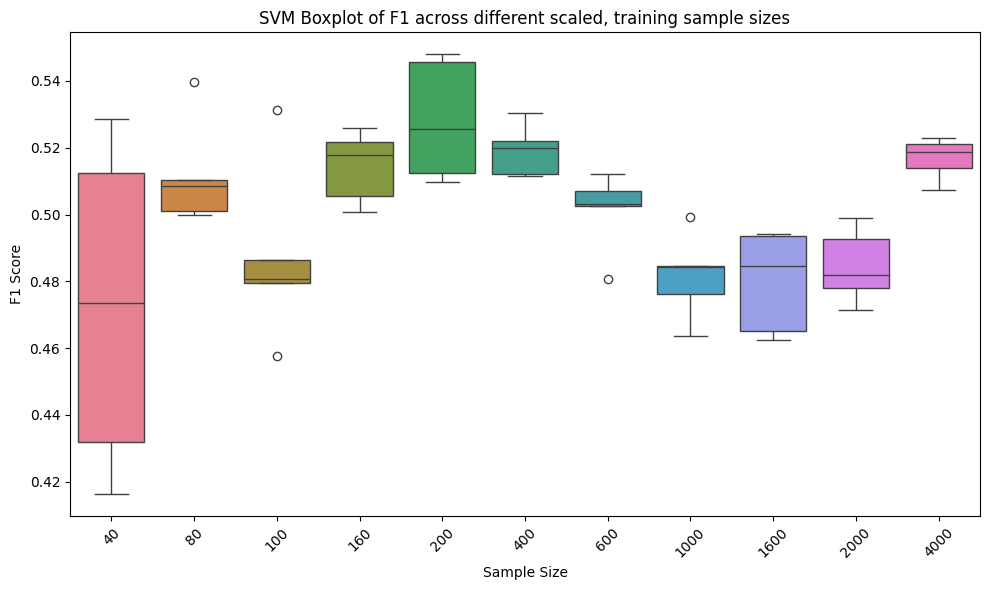\
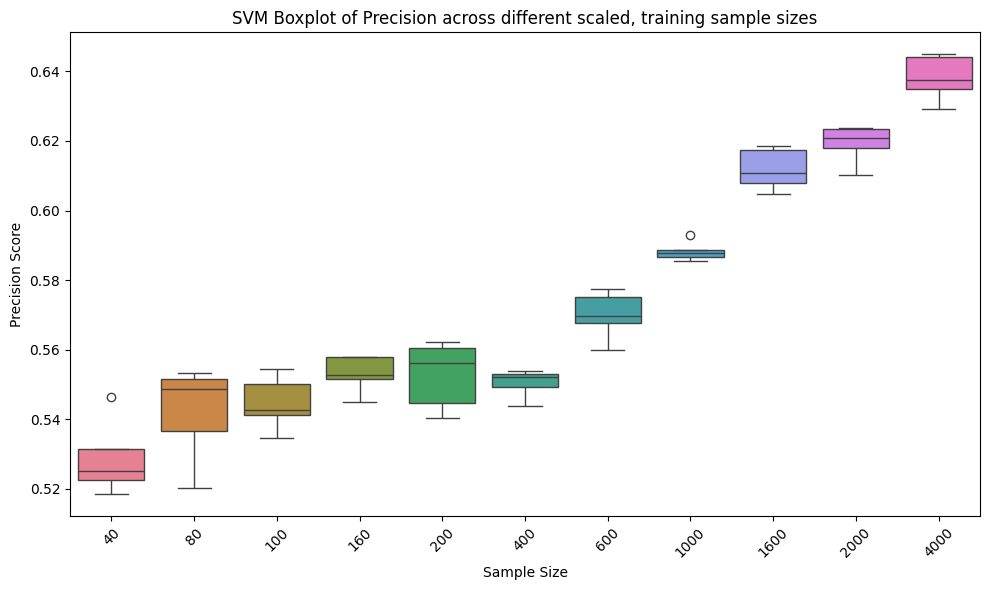\
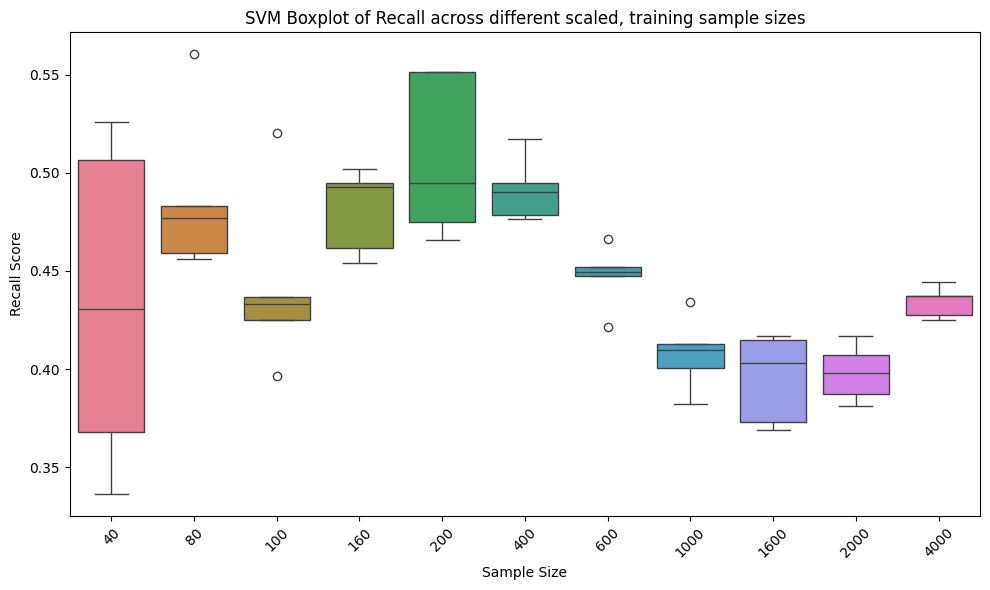\

There's interesting drop in performance over the training set size for the recall metric! I don't have a great explanation as to why, other than variance in the data and perhaps some unlikely data at those training set sizes started to skew the fitted model.

This SVM doesn't do very well at all. We discuss the results and why more in other sections [TODO].

# Fitted Mean, Cov Gaussian Processes


Let's look at the fitted model's progress on learning the mean and covariances of the underlying processes!

## Nominal Fitted Model
Let's first take another look at what the model should end up learning\
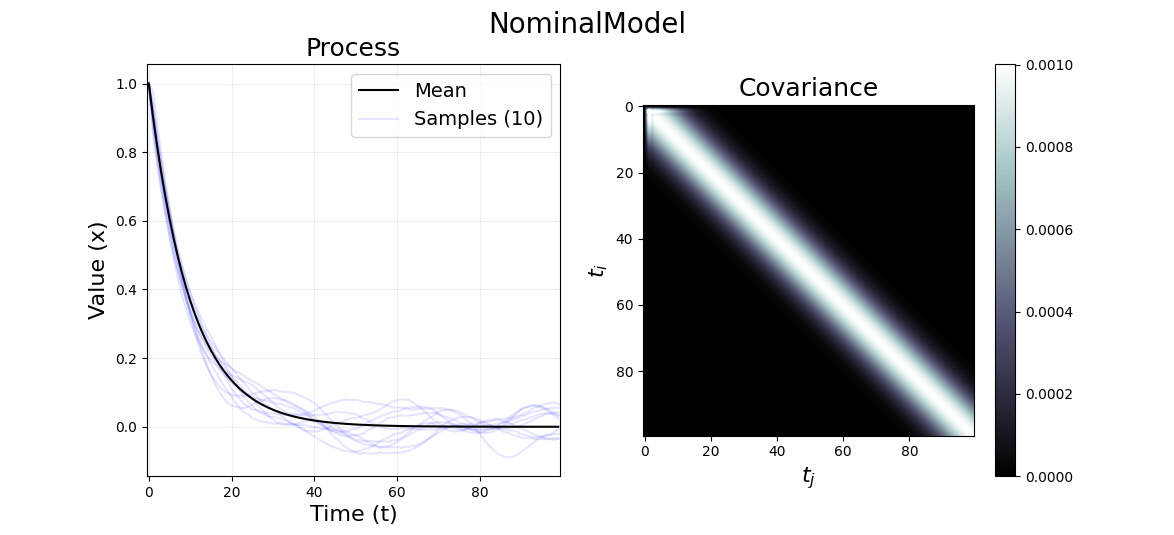

The fitted model, swept over different training set sizes (indicated in the title):\
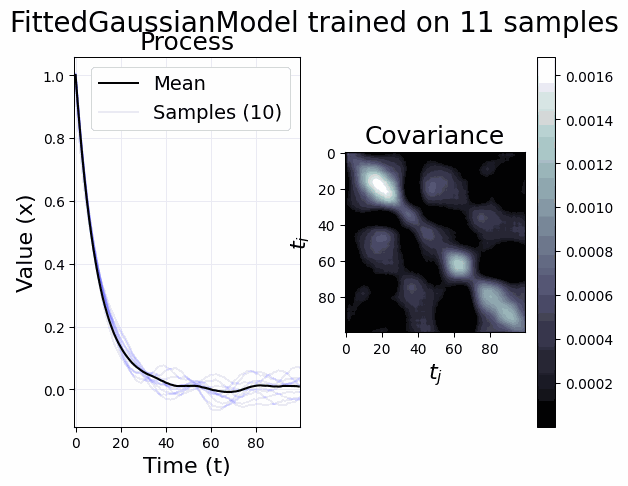

## Disrupted Fitted Model
Let's first take another look at what the model should end up learning\
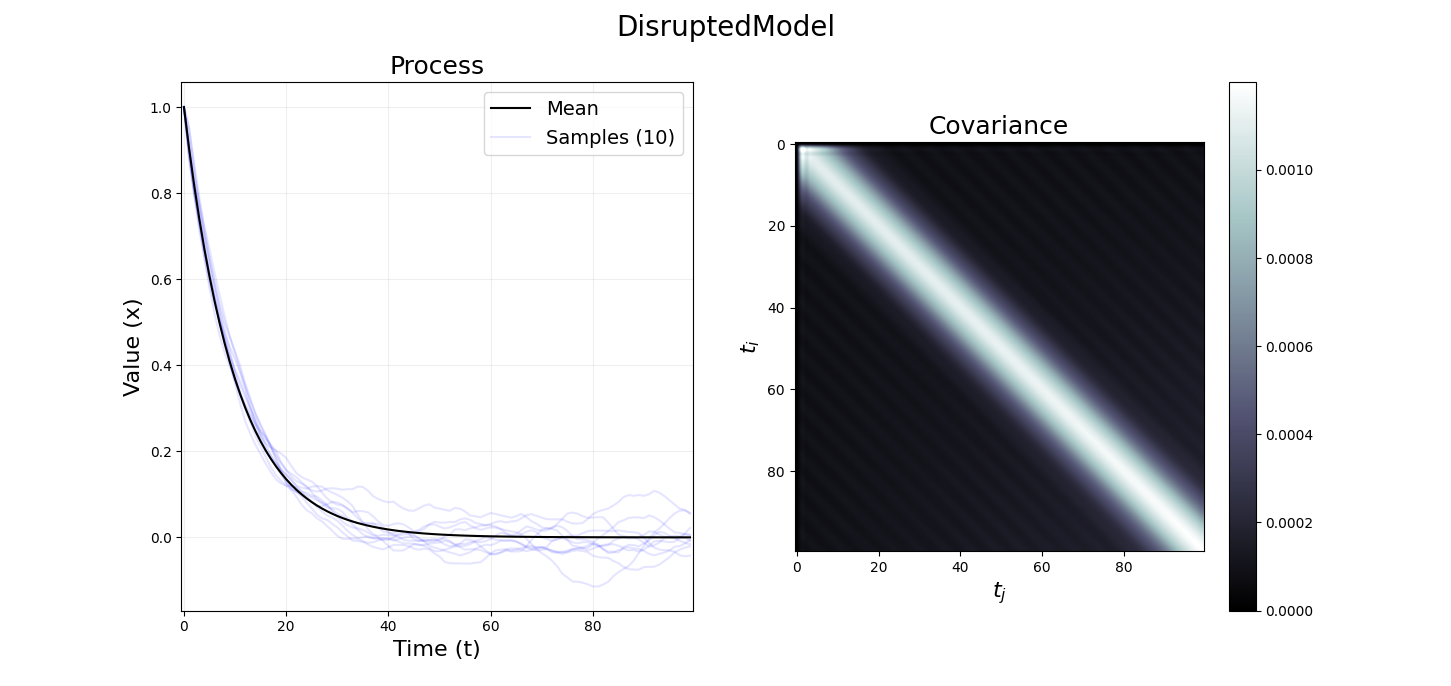

The fitted model, swept over different training set sizes (indicated in the title):\
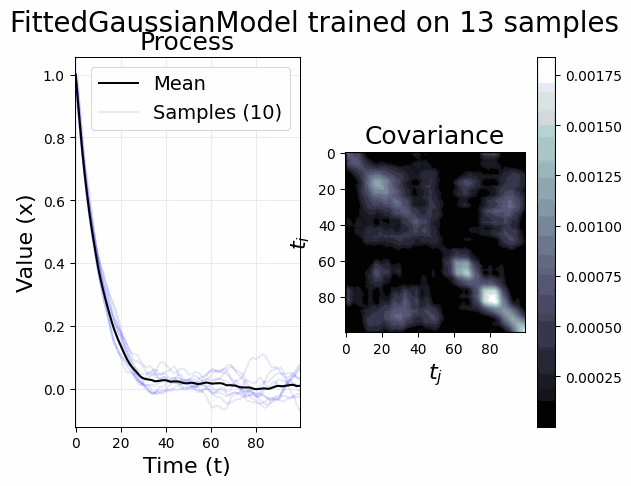

## Real-World Datasets
Unfortunately the fusion community does not open source most of their data. Disruption databases are usually held by the organization responsible for the tokamak.

However, any classification task where the classes are relatively-known dynamical systems or the family of distributions that the data comes from is known are applicable. 

### Extensions and their Challenges
Something that would be more deep-learning based, but is a realistic extension of this work to more scenarios, would be if Process A was a dynamical system (with control inputs, even) whose description is pretty well known, but Process B represented an anomalous state with relatively little data.

Turning the dynamical system into `P(X=x|C=c)` for the classification task presents a small challenge, but one that's quite common and can be tackled in many different ways. [This](https://astroautomata.com/blog/simulation-based-inference/) is a great blog post about doing just that!

## Challenges Encountered
Along the way, I ran into a number of numerical instability issues and challenges with forming a non-singular covariance matrix.
The covariance matrix for the generated processes was 100x100 and the Gaussians themselves were, of course, 100 dimensional. The determinant of this covariance matrix can be extraordinarily tiny for these high dimensions, which introduces some oddnesses down the line.

### Numerical issues with medium-sample sizes and singular (estimated) covariance matrices

For relatively large sample sizes, the covariance of data sampled from a hundred dimensional Gaussian can become almost zero along certain dimensions for small sample sizes very easily -- I added a demonstration of this in the `scripts` folder. It samples more and more values from a 100 dimensional Gaussian (with a much nicer covariance matrix than our processes) until it gets an estimated covariance matrix that isn't singular from those samples. The output of the cell below will tell you how many times it had to do this (increasing the number of samples each time) until it got one!


In [13]:
!poetry run python scripts/singular_matrices_from_small_samples.py

Took 304 to get a non-singular estimated covariance matrix 


To combat this, I compute the eigendecomposition of the covariance matrix and clip very small eigenvalues below 1e-6 to 1e-6 (anything smaller resulted in nan's and divide by zero errors as the determinant became numerically zero). Then I put the matrix back together. This is a relatively common technique for dealing with singular matrices, but I actually haven't heard a name for this process. 

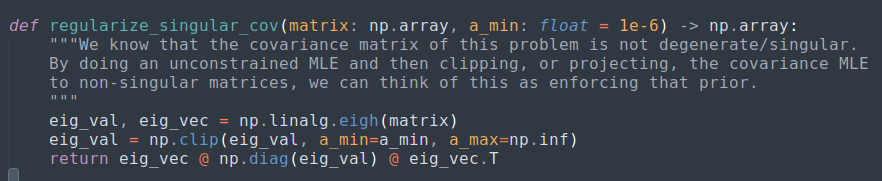

I'm thinking about this procedure as enforcing our strong prior that the underlying covariance matrix is **not singular**. We're projecting the matrix that would be numerically singular (thanks to numerical things) back into the non-singular matrix space. This takes our determinant of these "numerically" singular matrices from `is_close(det(A), 0.0) = True` to `is_close(det(A), 0.0) = False`.

# Conclusions

Even fitting both the mean and covariance for both Process A and Process B, the fitted Bayes classifier dramatically outperformed the SVM. 
It was quite difficult getting the SVM (and the NeuralNetwork that I don't even talk about) to learn anything meaningful about the dataset. 

Normalizing the dataset did help considerably, but you can see that the SVM struggled to perform better than a slightly-intuitive coin toss.

I believe this was because the problem is really an anomaly detection one for the SVM case. The nominal and disrupted generative processes are largely right on top of each other, with only higher variance in the disrupted process. 

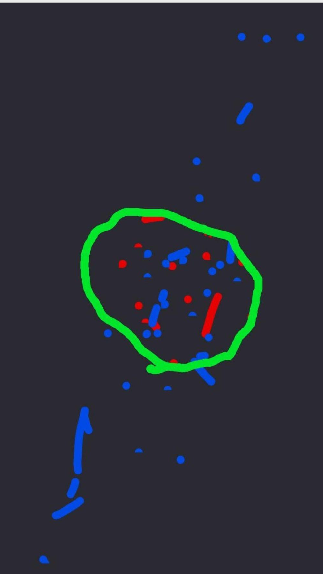

***Figure: Crude Representation of the challenge the SVM faces separating nominal from disrupted data in this case***

It's disappointing that the SVM did so poorly, it would have been much more interesting (and informative) to see a fairer fight between the Gaussian Process models and the discriminative. 

If I had more time, I would sweep how "disrupted" the nominal process is (play with the parameters in the covariance noise and add a parameter that affects the mean vector slightly for the disrupted process) to better illustrate examples where discriminative models could perform well, given enough data.

## Surprise!
And surprise! I just barely ended up having enough time. This is the distribution of accuracy scores for classifying Nominal vs Disrupted time series when **their means are no longer equal**. Incredibly, incredibly interestingly, the SVM does better than the Fitted Gaussians immediately. I believe this is because of the singular covariance matrix estimates we just discussed. While my fix improves the situation, it's non-optimal and only a few samples is just hard to work with for our GP models, even though we do see very good scores from the fitted Gaussian in very low-data regimes! 

Another incredibly important factor to the SVM's success is likely that the trajectories from these models in this *one hundred* dimensional space are actually very far apart and easily separable for this mean perturbation size.

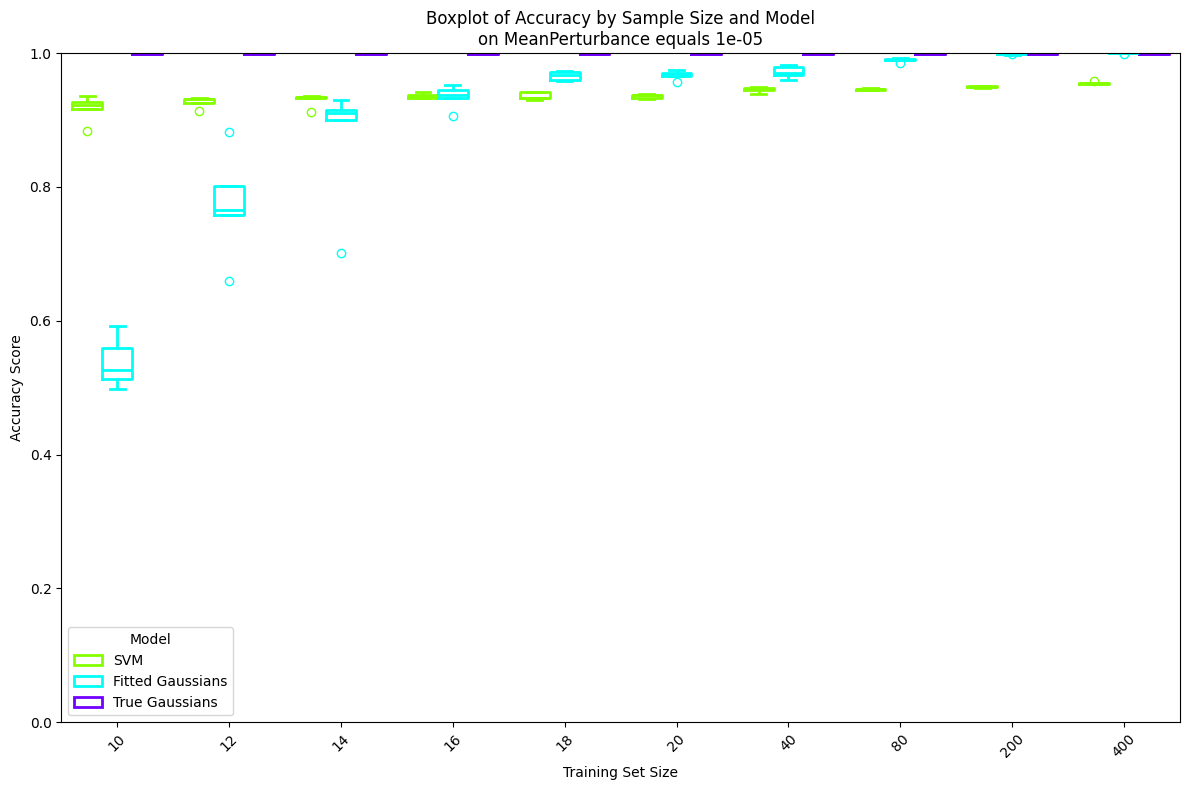

Then, the SVM model plateaus in accuracy, while the Fitted Bayes classifier asymptotes to the theoretical maximum! This is incredibly interesting to see, I really didn't have a guess on whether or not the SVM would outperform the Fitted Bayes model in the low data regimes. 

The mean perturbation gets added as `mean_perturbation*t^2` to the mean function:
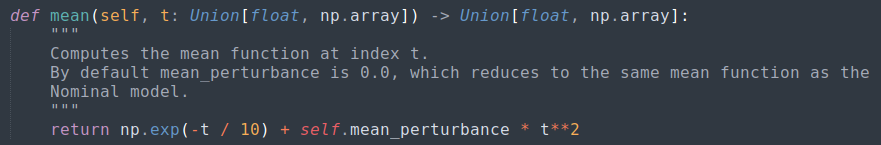

Since t ranges from 0 to 100, the mean perturbance will add 1e-5*100^2 to the mean vector at the end. This is how `mean_perturbance=1e-5` affects the sampled trajectories! While these still look fairly similar to the eye, the Mahalonbis distance for a trajectory coming from the wrong distribution is pretty astronomical. Notice that the True Gaussian model went from occasionally having a little noise to none at all in the boxplots above.

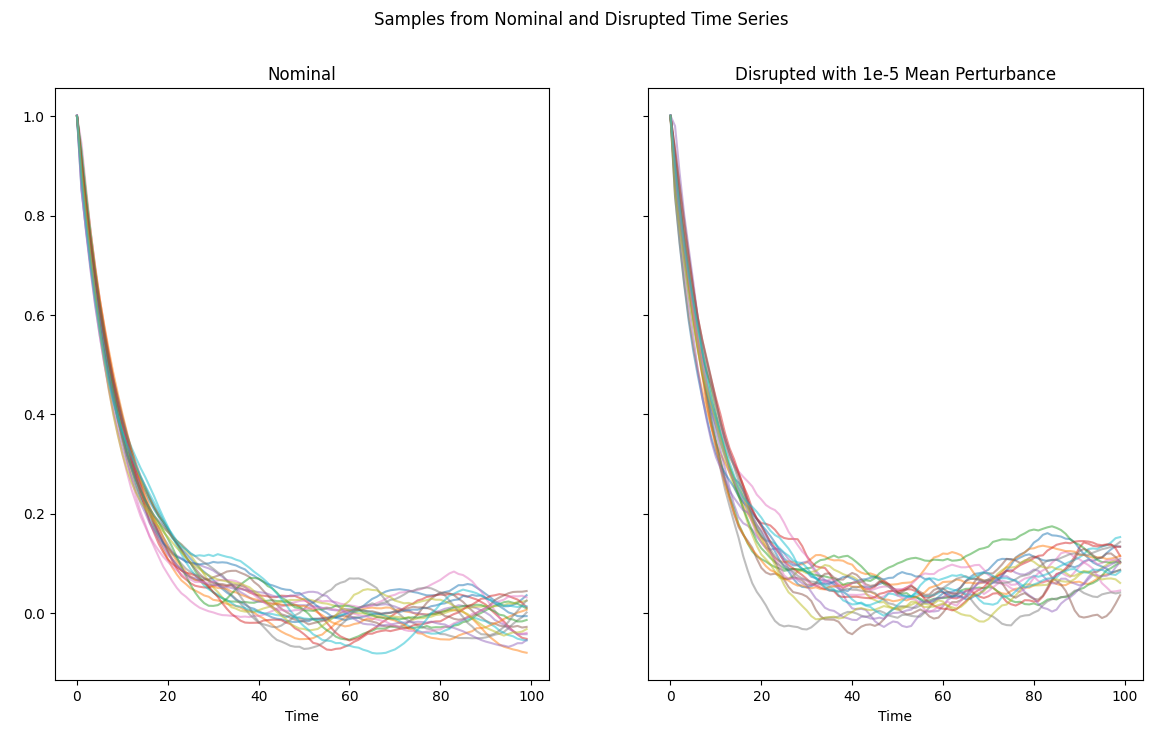
***Figure: Nominal and Disrupted Processes, this time with unequal means.***

For additional context (and a sanity check), a larger mean_perturbance does let the SVM perform almost optimally from *extremely* low data, but this parameter check likely made the problem almost trivially separable. 

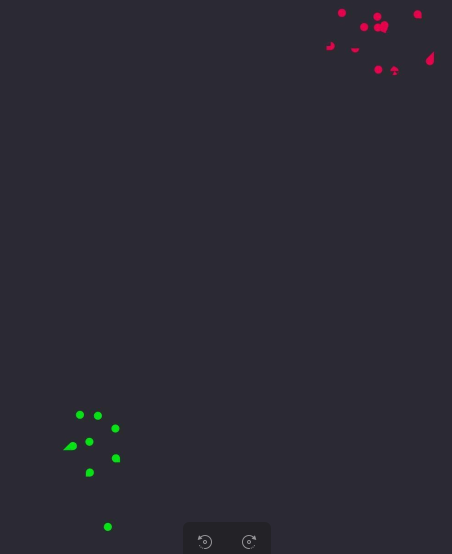\
***Figure: Crude representation of trivially separable problem to an SVM***

Predictably, we see the fitted Bayes model rapidly approach optimal and stay there. 
**My apologies for how difficult it is to see the distributions at the very top of the plot! They appear as colored lines on top of the borders.**

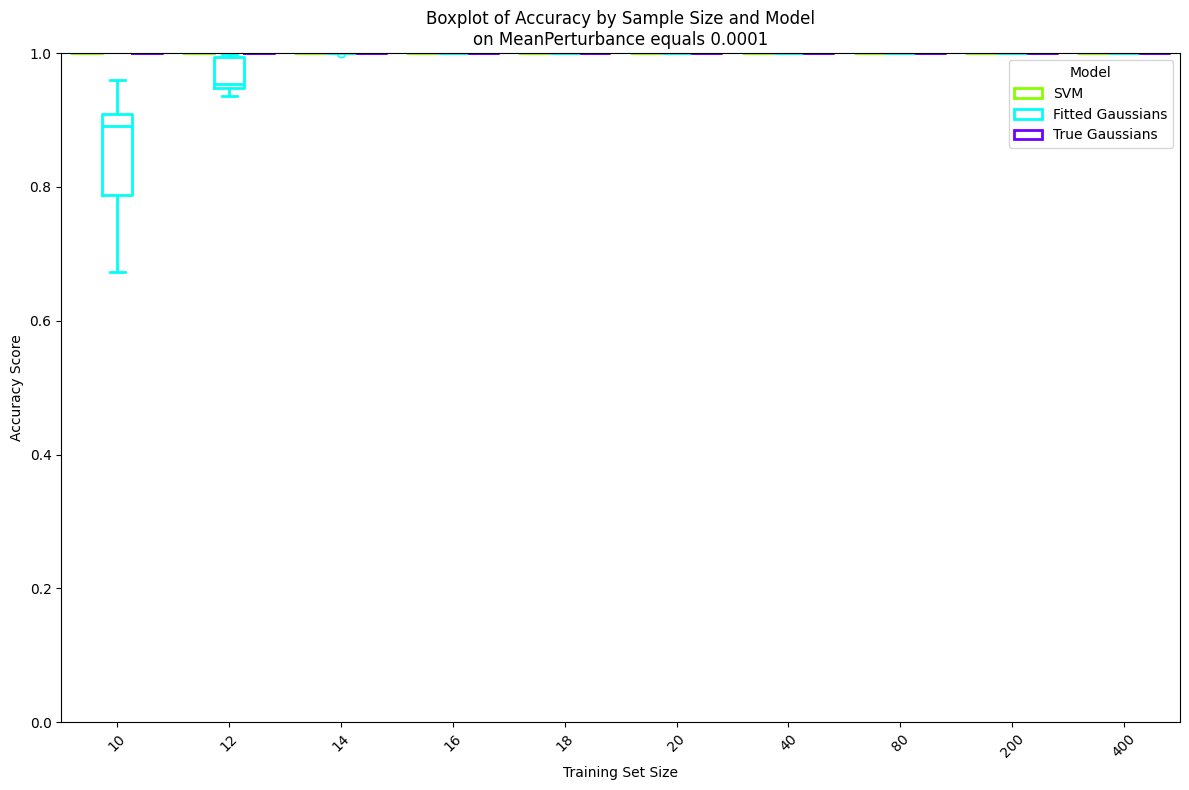


## Fitting Gaussian Processes
I claimed that we tested a large variety of scenarios representing differing amounts of prior knowledge about the distributions of Process A and Process B. However, nowhere did I fit A and B based on priors about the structure of the mean or covariance function. The mean function is an exponential curve that depends on time and the covariance function is shift-invariant. 

You could easily imagine a scenario where we know (perhaps from first principles models) that the mean function should be exponentially decaying, but we don't know the coefficients of that curve. We could have fit Process A and B based on that knowledge as well. However, this would likely involve making this system differentiable (& just-in-time compiled for the sake of runtime) in order to backprop to get gradients of the proposed mean function with respect to the model outputs. 

For fitting the shift-invariant covariance matrix, I'm not sure how I would fit a Toeplitz matrix in a way that respects the structure, but hopefully someone has published or written something on that kind of constrained optimization. 
These would both yield even better performance than our current mean and covariance fitting procedures, which are just the MLE of a general Gaussian Process.

This would probably make it much more difficult to the model to perform very well, which would make it more interesting to see against more discriminative models!

## Final Comments
Thank you for your feedback on my project proposal! I had a great time in your course, though I wish I'd been able to be more involved -- I just started a new job and I still haven't gotten the hang of the balancing act. This project was a lot of fun!\
I really wish that I'd been able to make an interactive set of plots for the disturbance parameter and the mean function factor to the disrupted model and their affects on the model accuracies (including the "best case" bayes classifier with the true distributions). I think it would have added a lot to everyone's takeways from the report, but hopefully the separately generated figures didn't detract too much from what could have been.

See you for the precapstone in a few weeks!

# References
Direct references are in the links throughout the document, wherever they get used!\
[1] https://distill.pub/2019/visual-exploration-gaussian-processes/